# Vanilla GAN on MNIST 

# Import 

In [16]:
''' basic package '''
import os
# 告訴系統要第幾張卡被看到。 Ex. 硬體總共有8張顯卡，以下設定只讓系統看到第1張顯卡
# 若沒設定，則 Tensorflow 在運行時，預設會把所有卡都佔用
# 要看裝置內顯卡數量及目前狀態的話，請在終端機內輸入 "nvidia-smi"
# 若你的裝置只有一張顯卡可以使用，可以忽略此設定
os.environ["CUDA_VISIBLE_DEVICES"] = '0'
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

''' tensorflow package '''
import tensorflow as tf
from tensorflow.examples.tutorials.mnist import input_data
from keras import datasets

# Config 

In [17]:
batch_size = 128
Z_dim = 100        # demesion of noise vector z for generator input
max_iter = 1000000
mnist = input_data.read_data_sets('MNIST_data/', one_hot=True)
#mnist = datasets.mnist.load_data()

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


# Train 

### 定義 generator & discriminator 

In [18]:
def xavier_init(size):
    in_dim = size[0]
    xavier_stddev = 1. / tf.sqrt(in_dim / 2.)
    return tf.random_normal(shape=size, stddev=xavier_stddev)

#### Define model ####
def generator(z):
    with tf.variable_scope('generator', reuse=tf.AUTO_REUSE):  
        with tf.variable_scope('hidden_layer'):
            # 請輸入程式碼
            G_W1 = tf.get_variable(name = 'weight_1', dtype=tf.float32, initializer=xavier_init([100, 128]))
            G_B1 = tf.get_variable(name = 'bias_1', dtype = tf.float32, initializer = tf.zeros(shape =[128]))
            G_h1 = tf.nn.relu(tf.matmul(z, G_W1) + G_B1)
        with tf.variable_scope('output_layer'):
            # 請輸入程式碼
            #784 = 28 * 28
            G_W2 = tf.get_variable(name = 'weight_2', dtype=tf.float32, initializer=xavier_init([128, 784]))
            G_B2 = tf.get_variable(name = 'bias_2', dtype = tf.float32, initializer = tf.zeros(shape =[784]))
            G_prob = tf.nn.sigmoid(tf.matmul(G_h1, G_W2) + G_B2)
                       

    return G_prob

def discriminator(x):
    with tf.variable_scope('discriminator', reuse=tf.AUTO_REUSE):
        with tf.variable_scope('hidden_layer'):
            # 請輸入程式碼
            D_W1 = tf.get_variable(name = 'weight_1', dtype=tf.float32, initializer=xavier_init([784, 128]))
            D_B1 = tf.get_variable(name = 'bias_1', dtype = tf.float32, initializer = tf.zeros(shape =[128]))
            D_h1 = tf.nn.relu(tf.matmul(x, D_W1) + D_B1)
            
        with tf.variable_scope('output_layer'):
            # 請輸入程式碼
            # 輸出一維，機率判定是不是同一張圖
            D_W2 = tf.get_variable(name = 'weight_2', dtype=tf.float32, initializer=xavier_init([128, 1]))
            D_B2 = tf.get_variable(name = 'bias_2', dtype = tf.float32, initializer = tf.zeros(shape =[1]))
            D_logit = tf.matmul(D_h1, D_W2) + D_B2
            D_prob = tf.nn.sigmoid(D_logit)
            
    return D_prob, D_logit


### Tensorflow- 建立靜態圖 

**靜態圖**就像一張計畫圖一樣，定義我們的計算流程。實際運算必須靠 **<span style="color:red;"> Session </span>** 來執行



In [19]:
main_graph = tf.Graph()
sess = tf.Session(graph=main_graph)

with main_graph.as_default():
    
    #### placeholder ####
    Z = tf.placeholder(name='z', dtype=tf.float32, shape=[None, 100]) # generator input
    input_img = tf.placeholder(name='x', dtype=tf.float32, shape=[None, 784]) # discriminator input

    #### GAN model output ####  
    G_sample = generator(Z)
    D_real, D_logit_real = discriminator(input_img)
    D_fake, D_logit_fake = discriminator(G_sample)

    #### loss ####
    D_loss_real = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=D_logit_real, labels=tf.ones_like(D_logit_real))) 
    D_loss_fake = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=D_logit_fake, labels=tf.zeros_like(D_logit_fake)))
    D_loss = D_loss_real + D_loss_fake
    G_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=D_logit_fake, labels=tf.ones_like(D_logit_fake)))

    #### variable list ####
    varList = tf.trainable_variables()
    G_varList = [var for var in varList if 'generator' in var.name]
    D_varList = [var for var in varList if 'discriminator' in var.name]
    
    #### update ####
    D_optimizer = tf.train.AdamOptimizer().minimize(D_loss, var_list=D_varList)
    G_optimizer = tf.train.AdamOptimizer().minimize(G_loss, var_list=G_varList)

    init = tf.global_variables_initializer()

### Tensorflow- 初始化模型

In [20]:
#### initialize model ####
sess.run(init)

### Tensorflow- 實際執行模型訓練

In [21]:
def sample_Z(m, n):
        return np.random.uniform(-1., 1., size=[m, n])

def plot(samples):
    fig = plt.figure(figsize=(4, 4))
    gs = gridspec.GridSpec(4, 4)
    gs.update(wspace=0.05, hspace=0.05)

    for i, sample in enumerate(samples):
        ax = plt.subplot(gs[i])
        plt.axis('off')
        ax.set_xticklabels([])
        ax.set_yticklabels([])
        ax.set_aspect('equal')
        plt.imshow(sample.reshape(28, 28), cmap='Greys_r')

    return fig

Iter: 0
D loss: 1.451
G_loss: 2.498


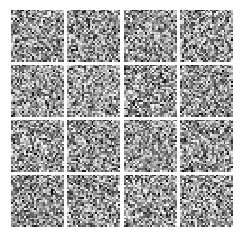

############################
Iter: 1000
D loss: 0.007787
G_loss: 6.935


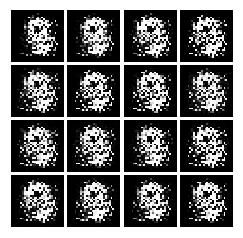

############################
Iter: 2000
D loss: 0.03283
G_loss: 5.183


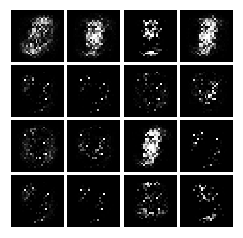

############################
Iter: 3000
D loss: 0.09163
G_loss: 5.304


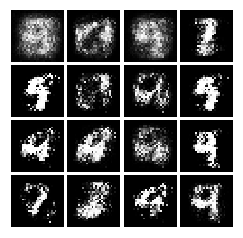

############################
Iter: 4000
D loss: 0.1534
G_loss: 5.284


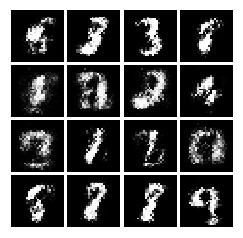

############################
Iter: 5000
D loss: 0.1871
G_loss: 5.484


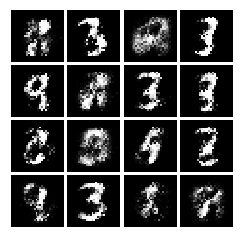

############################
Iter: 6000
D loss: 0.4353
G_loss: 4.088


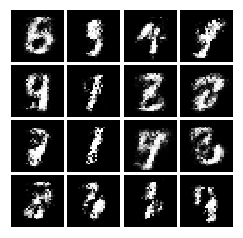

############################
Iter: 7000
D loss: 0.7095
G_loss: 3.492


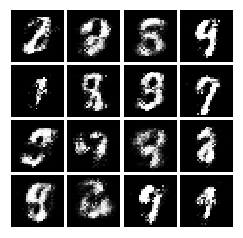

############################
Iter: 8000
D loss: 0.7124
G_loss: 3.151


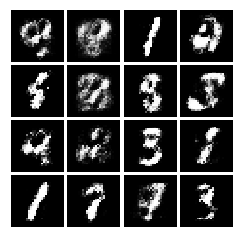

############################
Iter: 9000
D loss: 0.417
G_loss: 3.418


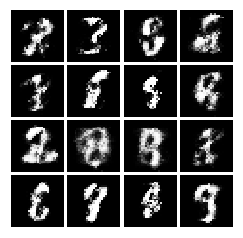

############################
Iter: 10000
D loss: 0.6555
G_loss: 3.262


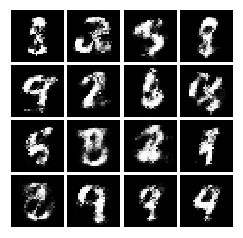

############################
Iter: 11000
D loss: 0.6278
G_loss: 3.348


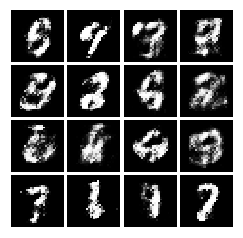

############################
Iter: 12000
D loss: 0.7298
G_loss: 2.798


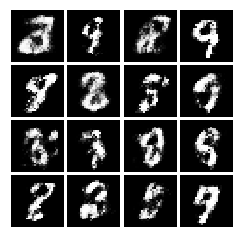

############################
Iter: 13000
D loss: 0.6648
G_loss: 2.769


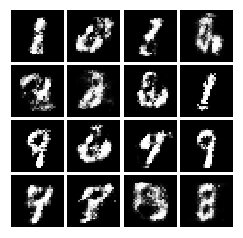

############################
Iter: 14000
D loss: 0.7638
G_loss: 2.227


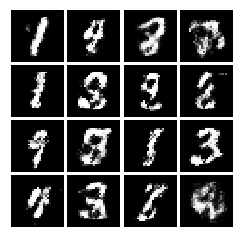

############################
Iter: 15000
D loss: 0.6684
G_loss: 2.697


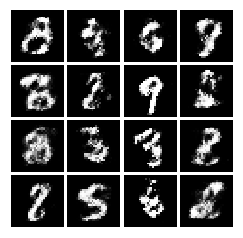

############################
Iter: 16000
D loss: 0.6544
G_loss: 2.787


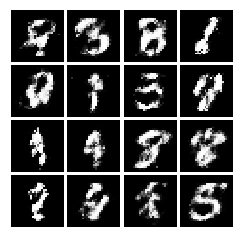

############################
Iter: 17000
D loss: 0.8712
G_loss: 2.09


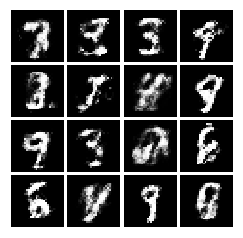

############################
Iter: 18000
D loss: 0.6448
G_loss: 2.223


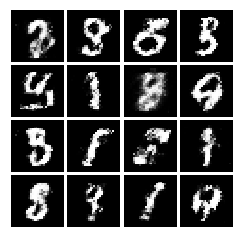

############################
Iter: 19000
D loss: 0.7348
G_loss: 2.488


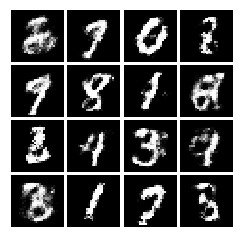

############################
Iter: 20000
D loss: 0.5988
G_loss: 2.066


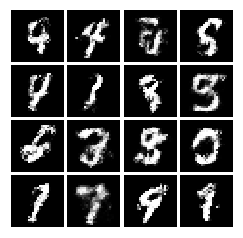

############################
Iter: 21000
D loss: 0.8795
G_loss: 2.173


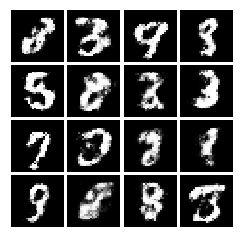

############################
Iter: 22000
D loss: 0.858
G_loss: 1.878


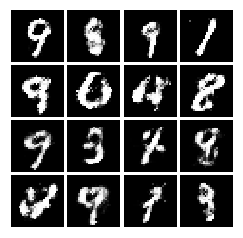

############################
Iter: 23000
D loss: 0.8234
G_loss: 2.364


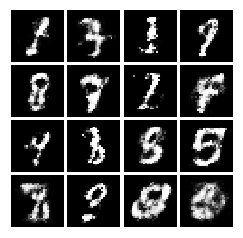

############################
Iter: 24000
D loss: 0.7878
G_loss: 1.796


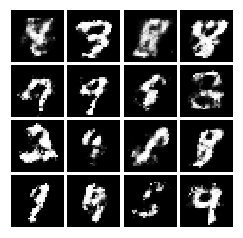

############################
Iter: 25000
D loss: 0.798
G_loss: 1.912


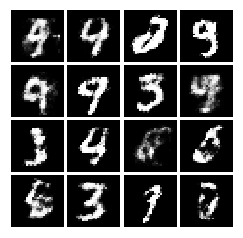

############################
Iter: 26000
D loss: 0.7607
G_loss: 2.115


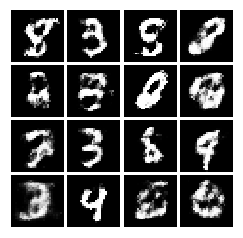

############################
Iter: 27000
D loss: 0.7426
G_loss: 1.959


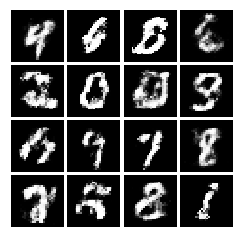

############################
Iter: 28000
D loss: 0.7355
G_loss: 2.073


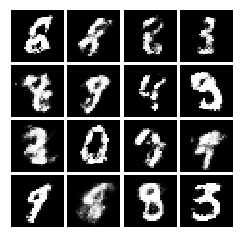

############################
Iter: 29000
D loss: 0.814
G_loss: 2.033


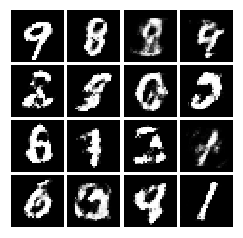

############################
Iter: 30000
D loss: 0.7857
G_loss: 2.0


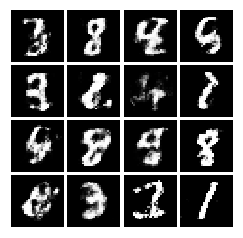

############################
Iter: 31000
D loss: 0.7404
G_loss: 1.95


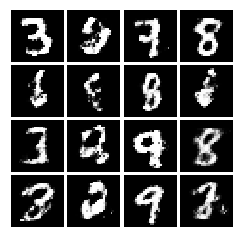

############################
Iter: 32000
D loss: 0.758
G_loss: 1.799


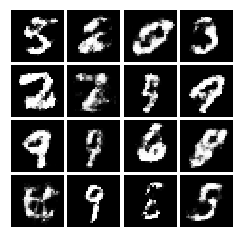

############################
Iter: 33000
D loss: 0.8325
G_loss: 2.084


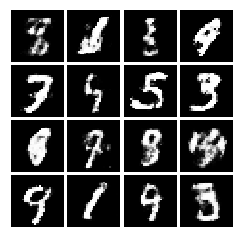

############################
Iter: 34000
D loss: 0.8031
G_loss: 2.187


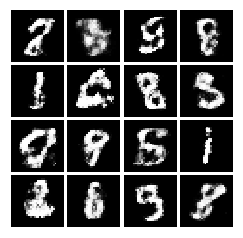

############################
Iter: 35000
D loss: 0.7166
G_loss: 1.955


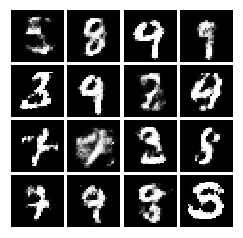

############################
Iter: 36000
D loss: 0.7045
G_loss: 2.076


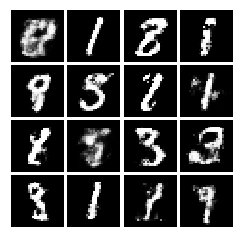

############################
Iter: 37000
D loss: 0.66
G_loss: 2.047


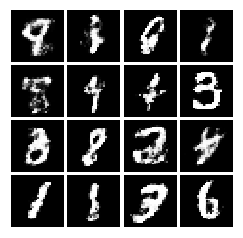

############################
Iter: 38000
D loss: 0.7841
G_loss: 2.278


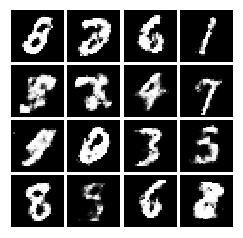

############################
Iter: 39000
D loss: 0.5794
G_loss: 2.319


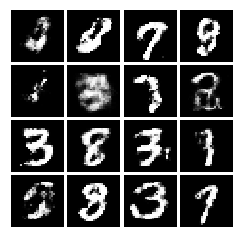

############################
Iter: 40000
D loss: 0.6502
G_loss: 2.42


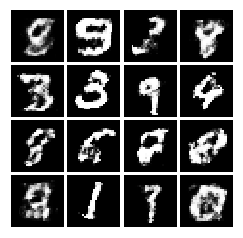

############################
Iter: 41000
D loss: 0.8166
G_loss: 2.319


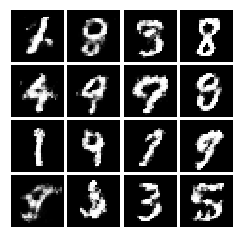

############################
Iter: 42000
D loss: 0.6859
G_loss: 2.38


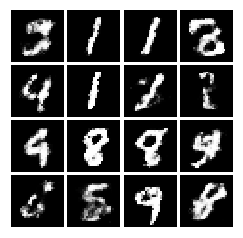

############################
Iter: 43000
D loss: 0.7876
G_loss: 1.747


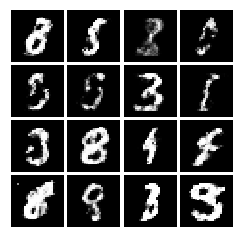

############################
Iter: 44000
D loss: 0.6335
G_loss: 2.249


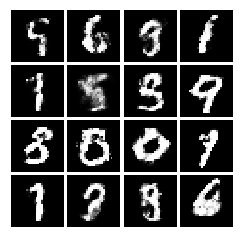

############################
Iter: 45000
D loss: 0.6215
G_loss: 2.376


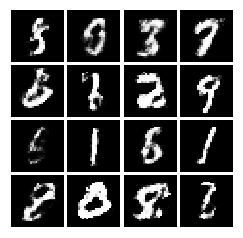

############################
Iter: 46000
D loss: 0.7333
G_loss: 2.362


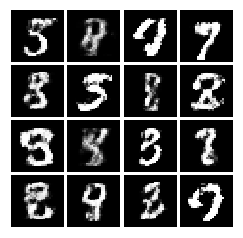

############################
Iter: 47000
D loss: 0.5765
G_loss: 2.425


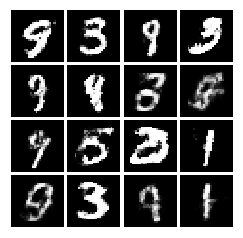

############################
Iter: 48000
D loss: 0.7828
G_loss: 2.05


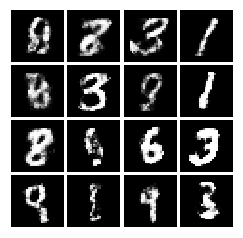

############################
Iter: 49000
D loss: 0.7215
G_loss: 2.584


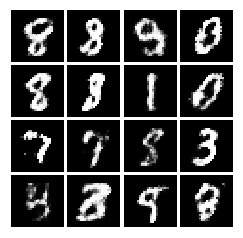

############################
Iter: 50000
D loss: 0.7072
G_loss: 2.02


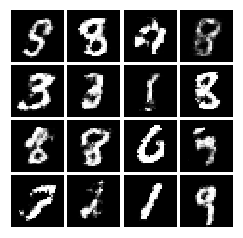

############################
Iter: 51000
D loss: 0.6792
G_loss: 2.052


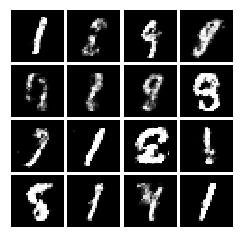

############################
Iter: 52000
D loss: 0.685
G_loss: 2.65


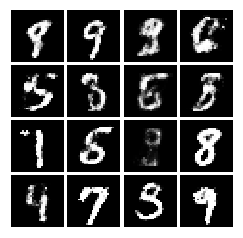

############################
Iter: 53000
D loss: 0.7067
G_loss: 2.463


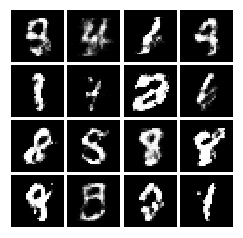

############################
Iter: 54000
D loss: 0.6236
G_loss: 2.601


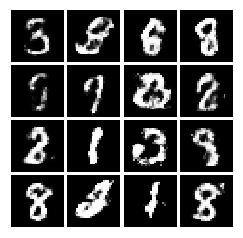

############################
Iter: 55000
D loss: 0.6238
G_loss: 2.522


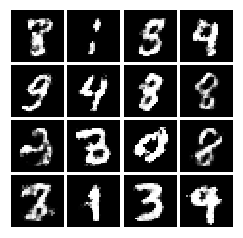

############################
Iter: 56000
D loss: 0.6671
G_loss: 2.289


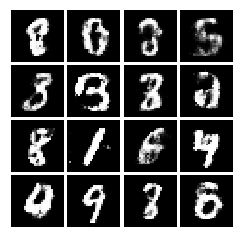

############################
Iter: 57000
D loss: 0.5435
G_loss: 2.754


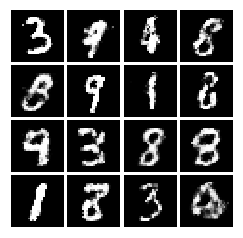

############################
Iter: 58000
D loss: 0.715
G_loss: 2.178


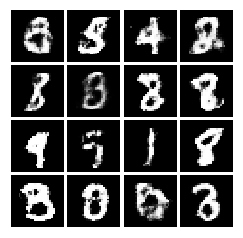

############################
Iter: 59000
D loss: 0.716
G_loss: 2.157


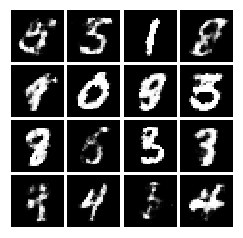

############################
Iter: 60000
D loss: 0.6342
G_loss: 2.473


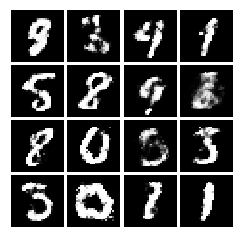

############################
Iter: 61000
D loss: 0.6639
G_loss: 2.281


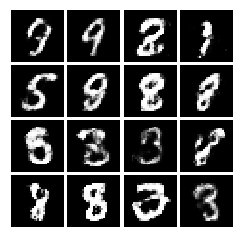

############################
Iter: 62000
D loss: 0.6211
G_loss: 2.023


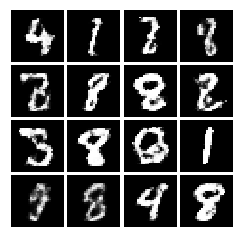

############################
Iter: 63000
D loss: 0.5736
G_loss: 2.009


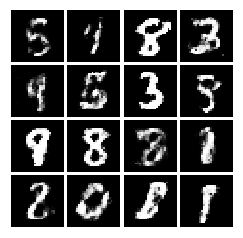

############################
Iter: 64000
D loss: 0.6465
G_loss: 2.332


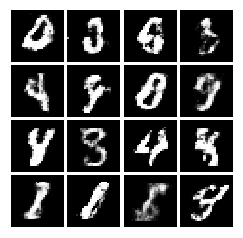

############################
Iter: 65000
D loss: 0.6784
G_loss: 2.499


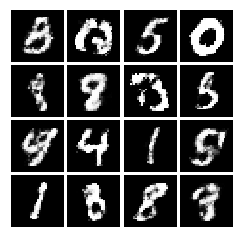

############################
Iter: 66000
D loss: 0.5897
G_loss: 2.433


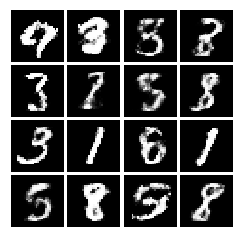

############################
Iter: 67000
D loss: 0.6104
G_loss: 2.633


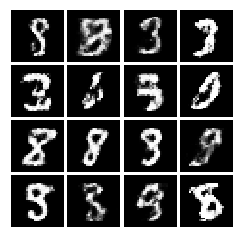

############################
Iter: 68000
D loss: 0.5216
G_loss: 2.576


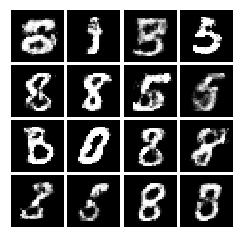

############################
Iter: 69000
D loss: 0.5456
G_loss: 1.911


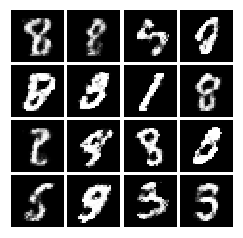

############################
Iter: 70000
D loss: 0.6888
G_loss: 2.456


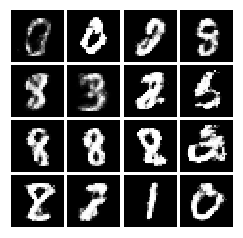

############################
Iter: 71000
D loss: 0.5781
G_loss: 2.574


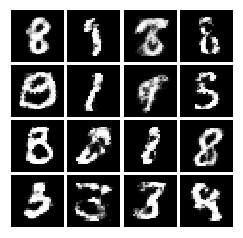

############################
Iter: 72000
D loss: 0.7205
G_loss: 2.249


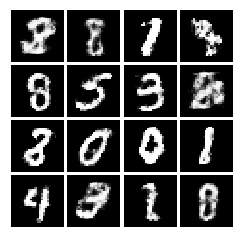

############################
Iter: 73000
D loss: 0.7953
G_loss: 2.257


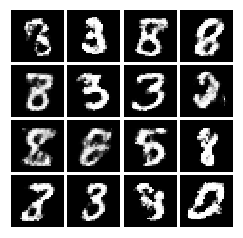

############################
Iter: 74000
D loss: 0.6434
G_loss: 2.458


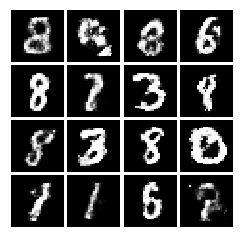

############################
Iter: 75000
D loss: 0.646
G_loss: 2.004


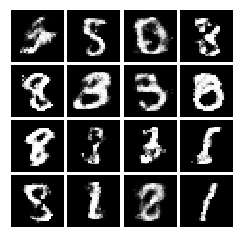

############################
Iter: 76000
D loss: 0.6213
G_loss: 2.4


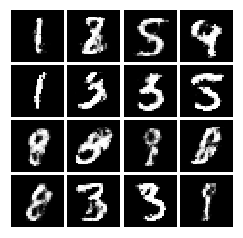

############################
Iter: 77000
D loss: 0.6687
G_loss: 2.351


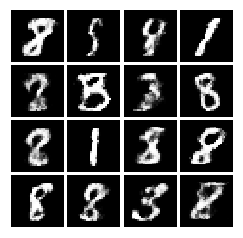

############################
Iter: 78000
D loss: 0.7633
G_loss: 2.18


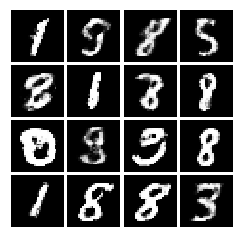

############################
Iter: 79000
D loss: 0.5898
G_loss: 2.307


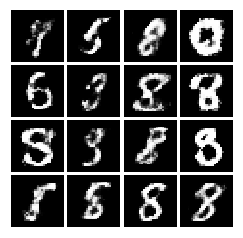

############################
Iter: 80000
D loss: 0.6268
G_loss: 2.254


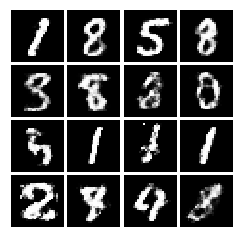

############################
Iter: 81000
D loss: 0.6501
G_loss: 1.912


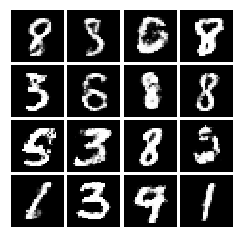

############################
Iter: 82000
D loss: 0.6379
G_loss: 2.262


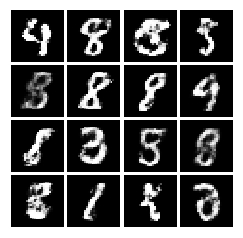

############################
Iter: 83000
D loss: 0.6558
G_loss: 2.491


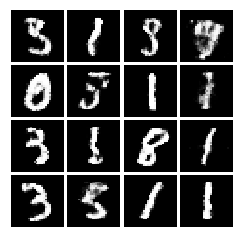

############################
Iter: 84000
D loss: 0.5846
G_loss: 2.313


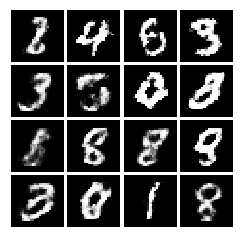

############################
Iter: 85000
D loss: 0.5461
G_loss: 2.215


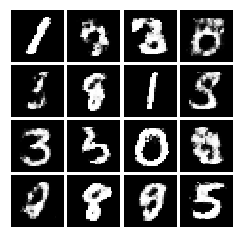

############################
Iter: 86000
D loss: 0.6272
G_loss: 2.287


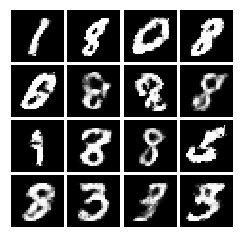

############################
Iter: 87000
D loss: 0.4991
G_loss: 2.107


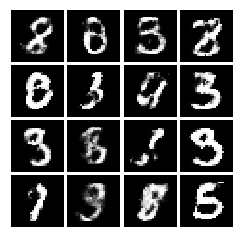

############################
Iter: 88000
D loss: 0.823
G_loss: 2.222


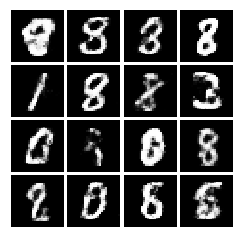

############################
Iter: 89000
D loss: 0.5579
G_loss: 2.15


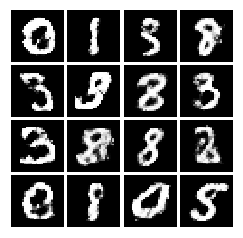

############################
Iter: 90000
D loss: 0.553
G_loss: 2.183


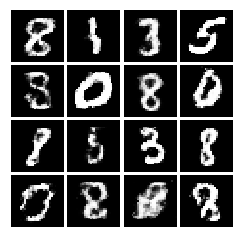

############################
Iter: 91000
D loss: 0.6103
G_loss: 2.438


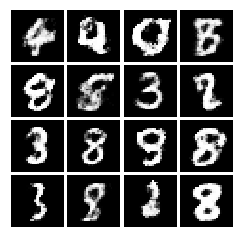

############################
Iter: 92000
D loss: 0.5876
G_loss: 2.508


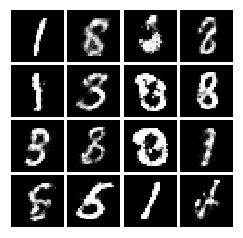

############################
Iter: 93000
D loss: 0.5674
G_loss: 2.109


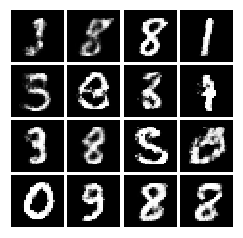

############################
Iter: 94000
D loss: 0.6947
G_loss: 2.254


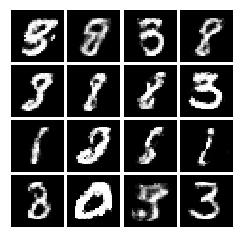

############################
Iter: 95000
D loss: 0.6544
G_loss: 2.169


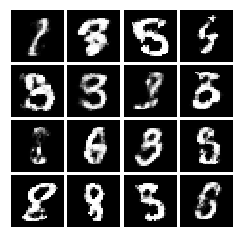

############################
Iter: 96000
D loss: 0.5202
G_loss: 2.278


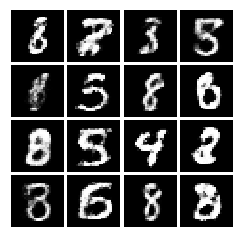

############################
Iter: 97000
D loss: 0.7392
G_loss: 2.126


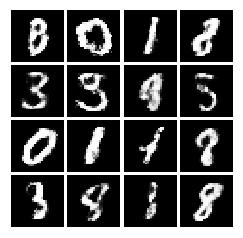

############################
Iter: 98000
D loss: 0.5914
G_loss: 2.251


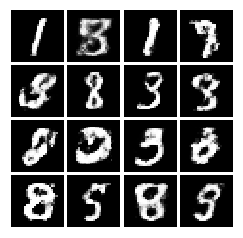

############################
Iter: 99000
D loss: 0.5314
G_loss: 2.275


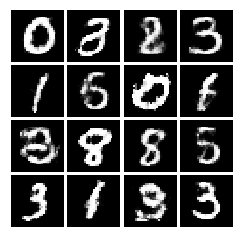

############################
Iter: 100000
D loss: 0.5911
G_loss: 2.193


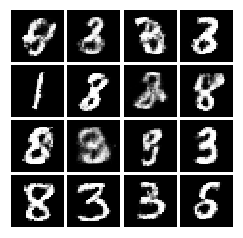

############################
Iter: 101000
D loss: 0.5407
G_loss: 2.209


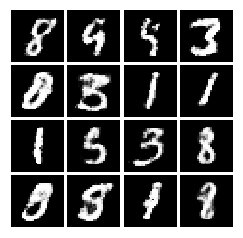

############################
Iter: 102000
D loss: 0.5784
G_loss: 2.159


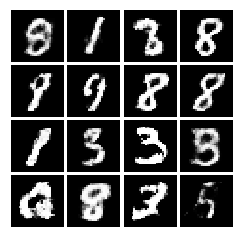

############################
Iter: 103000
D loss: 0.5427
G_loss: 2.491


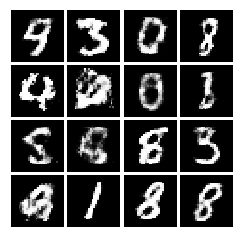

############################
Iter: 104000
D loss: 0.5594
G_loss: 2.357


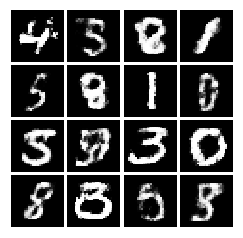

############################
Iter: 105000
D loss: 0.5513
G_loss: 2.315


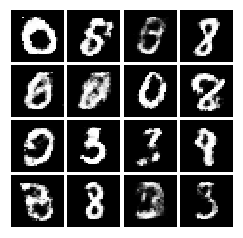

############################
Iter: 106000
D loss: 0.6597
G_loss: 2.509


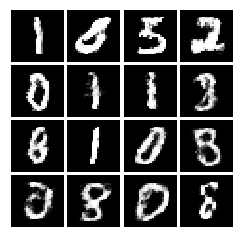

############################
Iter: 107000
D loss: 0.5494
G_loss: 2.249


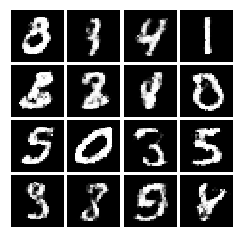

############################
Iter: 108000
D loss: 0.5681
G_loss: 2.188


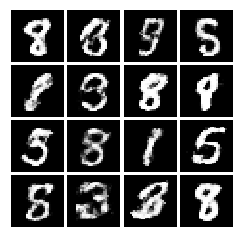

############################
Iter: 109000
D loss: 0.624
G_loss: 2.385


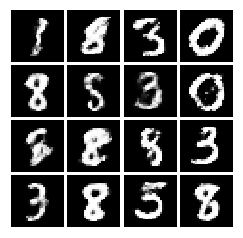

############################
Iter: 110000
D loss: 0.5919
G_loss: 2.351


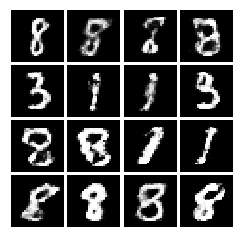

############################
Iter: 111000
D loss: 0.5426
G_loss: 2.585


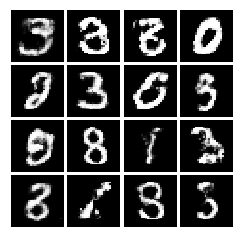

############################
Iter: 112000
D loss: 0.5674
G_loss: 2.631


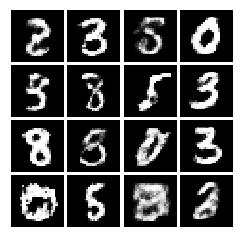

############################
Iter: 113000
D loss: 0.5781
G_loss: 2.552


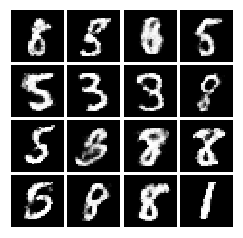

############################
Iter: 114000
D loss: 0.6471
G_loss: 2.381


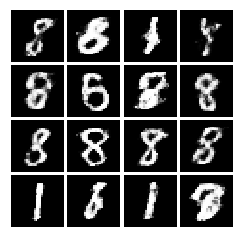

############################
Iter: 115000
D loss: 0.5924
G_loss: 2.351


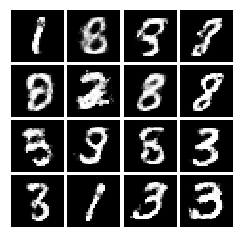

############################
Iter: 116000
D loss: 0.5353
G_loss: 2.555


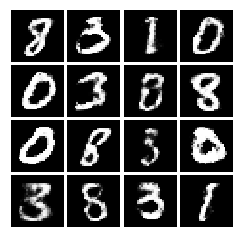

############################
Iter: 117000
D loss: 0.5174
G_loss: 2.189


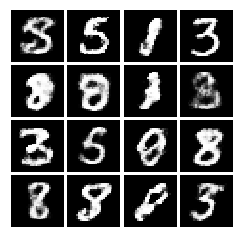

############################
Iter: 118000
D loss: 0.6012
G_loss: 2.314


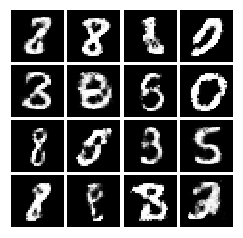

############################
Iter: 119000
D loss: 0.48
G_loss: 2.331


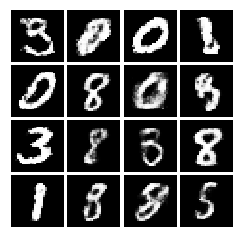

############################
Iter: 120000
D loss: 0.5245
G_loss: 2.273


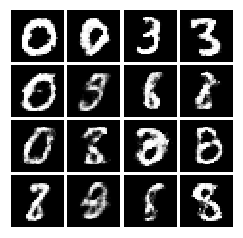

############################
Iter: 121000
D loss: 0.5155
G_loss: 2.119


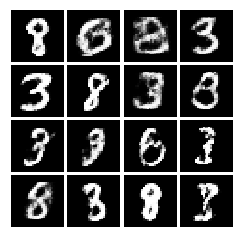

############################
Iter: 122000
D loss: 0.4751
G_loss: 2.271


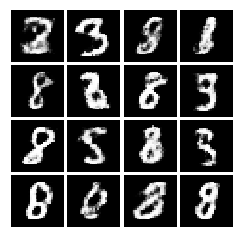

############################
Iter: 123000
D loss: 0.6269
G_loss: 3.066


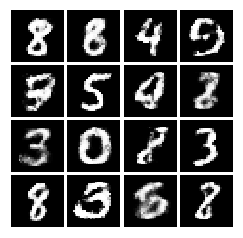

############################
Iter: 124000
D loss: 0.6197
G_loss: 2.196


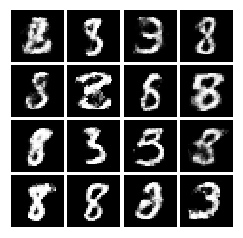

############################
Iter: 125000
D loss: 0.4708
G_loss: 2.095


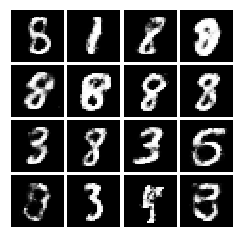

############################
Iter: 126000
D loss: 0.5115
G_loss: 2.268


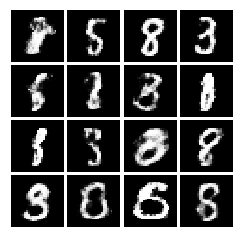

############################
Iter: 127000
D loss: 0.595
G_loss: 2.465


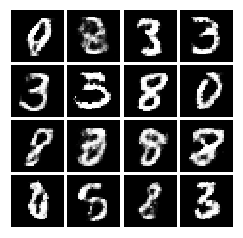

############################
Iter: 128000
D loss: 0.6315
G_loss: 2.406


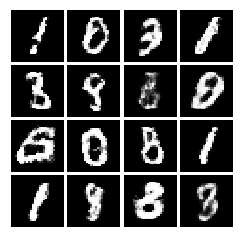

############################
Iter: 129000
D loss: 0.5857
G_loss: 2.656


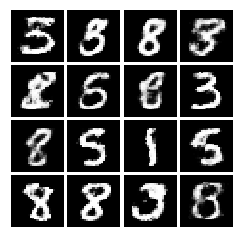

############################
Iter: 130000
D loss: 0.4375
G_loss: 2.494


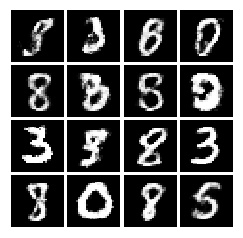

############################
Iter: 131000
D loss: 0.7135
G_loss: 2.356


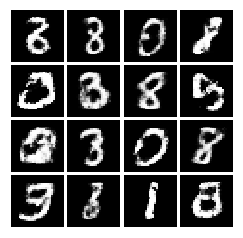

############################
Iter: 132000
D loss: 0.5687
G_loss: 2.697


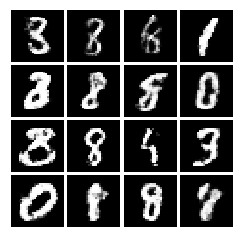

############################
Iter: 133000
D loss: 0.5418
G_loss: 2.421


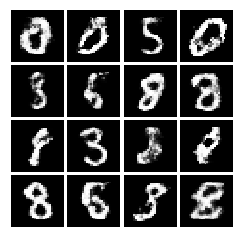

############################
Iter: 134000
D loss: 0.598
G_loss: 2.52


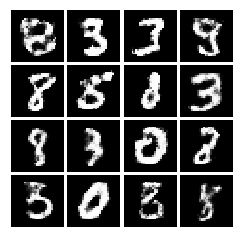

############################
Iter: 135000
D loss: 0.7257
G_loss: 2.431


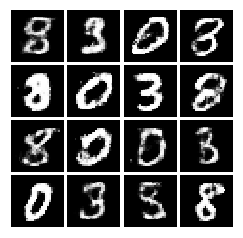

############################
Iter: 136000
D loss: 0.6556
G_loss: 2.214


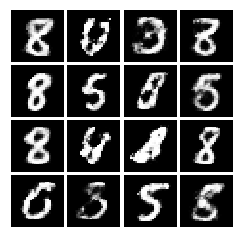

############################
Iter: 137000
D loss: 0.6403
G_loss: 2.052


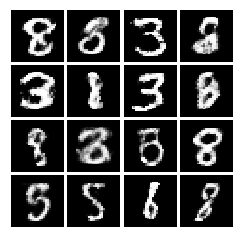

############################
Iter: 138000
D loss: 0.6318
G_loss: 2.551


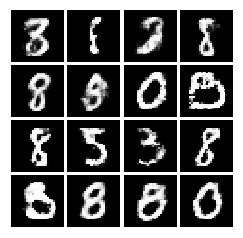

############################
Iter: 139000
D loss: 0.4392
G_loss: 2.497


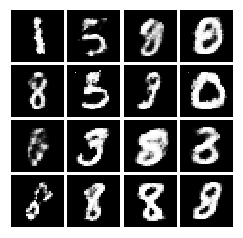

############################
Iter: 140000
D loss: 0.5863
G_loss: 2.498


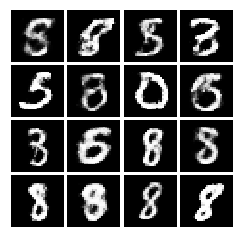

############################
Iter: 141000
D loss: 0.4999
G_loss: 2.432


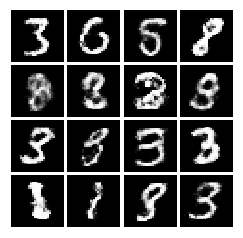

############################
Iter: 142000
D loss: 0.4603
G_loss: 2.172


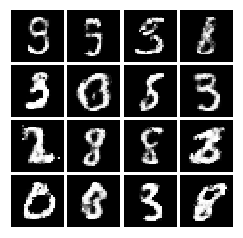

############################
Iter: 143000
D loss: 0.5829
G_loss: 2.209


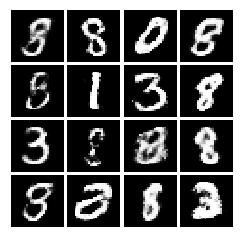

############################
Iter: 144000
D loss: 0.4452
G_loss: 2.383


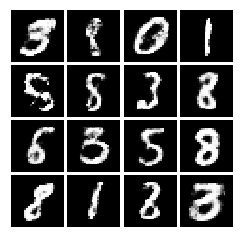

############################
Iter: 145000
D loss: 0.5374
G_loss: 2.366


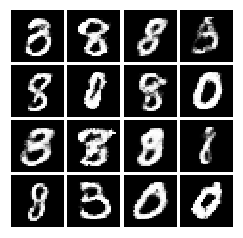

############################
Iter: 146000
D loss: 0.431
G_loss: 2.432


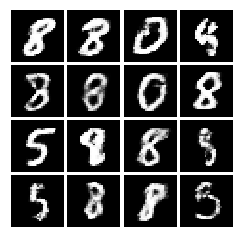

############################
Iter: 147000
D loss: 0.5335
G_loss: 2.609


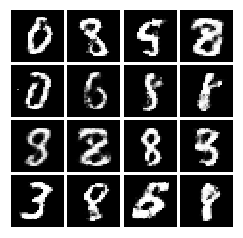

############################
Iter: 148000
D loss: 0.6237
G_loss: 2.294


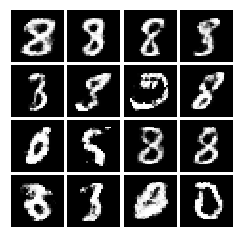

############################
Iter: 149000
D loss: 0.5658
G_loss: 2.337


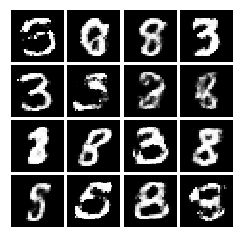

############################
Iter: 150000
D loss: 0.5196
G_loss: 2.436


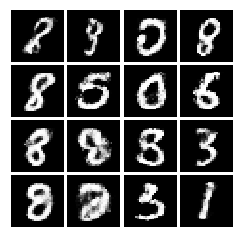

############################
Iter: 151000
D loss: 0.4398
G_loss: 2.23


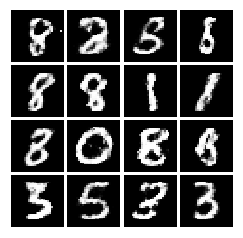

############################
Iter: 152000
D loss: 0.5944
G_loss: 2.293


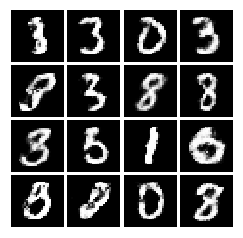

############################
Iter: 153000
D loss: 0.5234
G_loss: 2.829


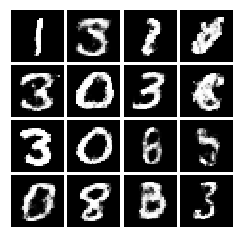

############################
Iter: 154000
D loss: 0.64
G_loss: 2.661


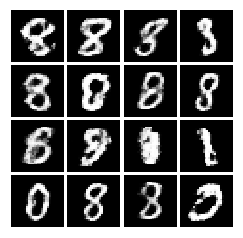

############################
Iter: 155000
D loss: 0.5075
G_loss: 2.93


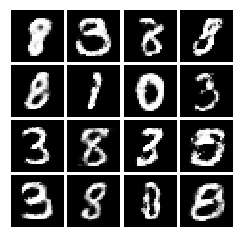

############################
Iter: 156000
D loss: 0.6237
G_loss: 2.396


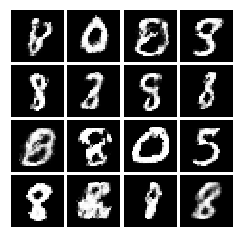

############################
Iter: 157000
D loss: 0.4252
G_loss: 2.502


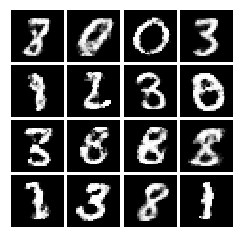

############################
Iter: 158000
D loss: 0.4524
G_loss: 2.746


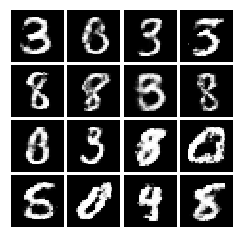

############################
Iter: 159000
D loss: 0.484
G_loss: 2.735


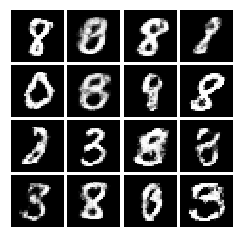

############################
Iter: 160000
D loss: 0.6078
G_loss: 2.381


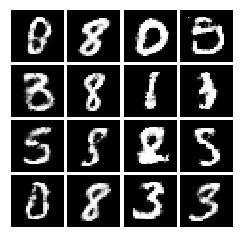

############################
Iter: 161000
D loss: 0.637
G_loss: 2.11


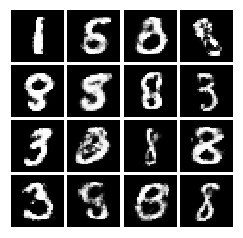

############################
Iter: 162000
D loss: 0.6113
G_loss: 2.531


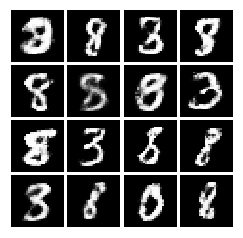

############################
Iter: 163000
D loss: 0.4707
G_loss: 2.724


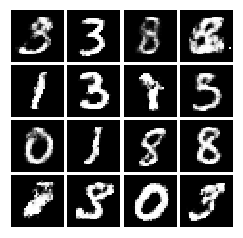

############################
Iter: 164000
D loss: 0.6128
G_loss: 2.766


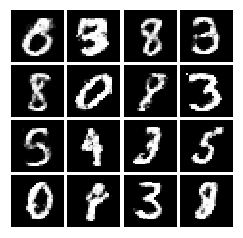

############################
Iter: 165000
D loss: 0.548
G_loss: 2.574


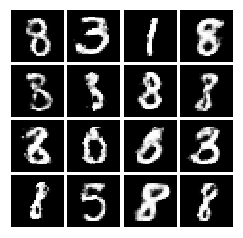

############################
Iter: 166000
D loss: 0.5338
G_loss: 2.586


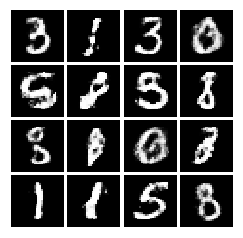

############################
Iter: 167000
D loss: 0.4439
G_loss: 2.731


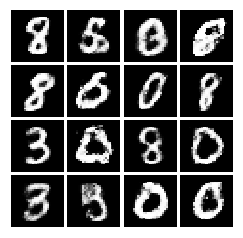

############################
Iter: 168000
D loss: 0.5732
G_loss: 2.375


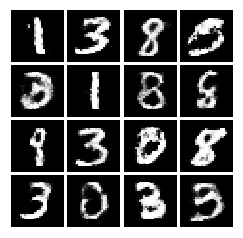

############################
Iter: 169000
D loss: 0.4738
G_loss: 2.635


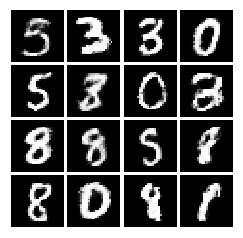

############################
Iter: 170000
D loss: 0.5461
G_loss: 2.619


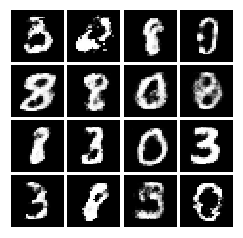

############################
Iter: 171000
D loss: 0.4992
G_loss: 2.588


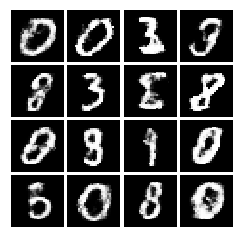

############################
Iter: 172000
D loss: 0.6622
G_loss: 2.72


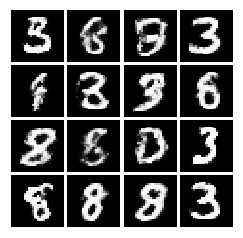

############################
Iter: 173000
D loss: 0.4241
G_loss: 2.65


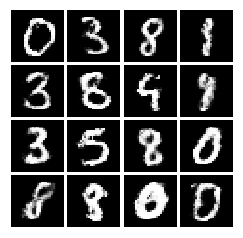

############################
Iter: 174000
D loss: 0.7734
G_loss: 2.517


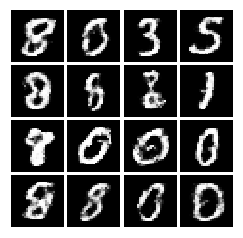

############################
Iter: 175000
D loss: 0.5266
G_loss: 2.524


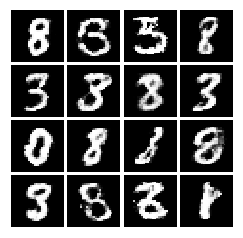

############################
Iter: 176000
D loss: 0.5665
G_loss: 3.048


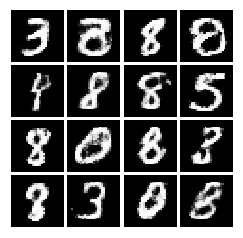

############################
Iter: 177000
D loss: 0.54
G_loss: 2.379


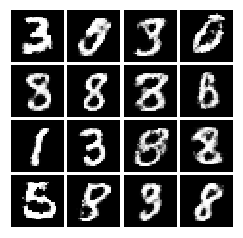

############################
Iter: 178000
D loss: 0.5261
G_loss: 2.591


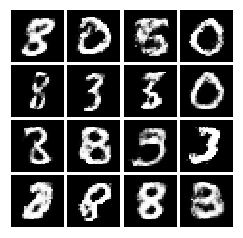

############################
Iter: 179000
D loss: 0.6157
G_loss: 2.581


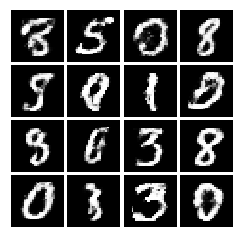

############################
Iter: 180000
D loss: 0.4735
G_loss: 2.677


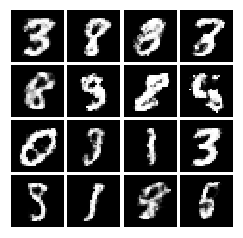

############################
Iter: 181000
D loss: 0.4799
G_loss: 2.823


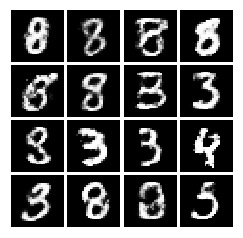

############################
Iter: 182000
D loss: 0.4483
G_loss: 2.698


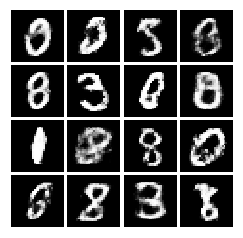

############################
Iter: 183000
D loss: 0.4799
G_loss: 2.677


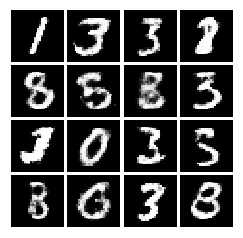

############################
Iter: 184000
D loss: 0.5679
G_loss: 3.108


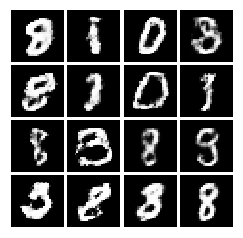

############################
Iter: 185000
D loss: 0.4875
G_loss: 2.477


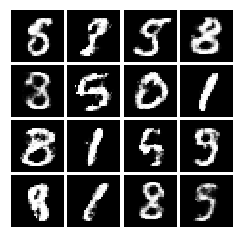

############################
Iter: 186000
D loss: 0.5103
G_loss: 2.583


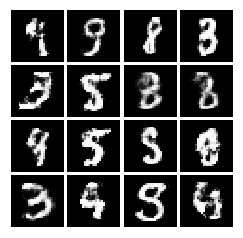

############################
Iter: 187000
D loss: 0.5
G_loss: 2.849


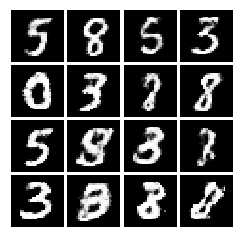

############################
Iter: 188000
D loss: 0.5199
G_loss: 2.33


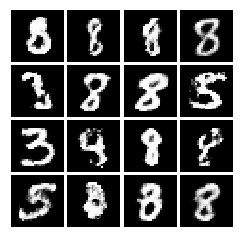

############################
Iter: 189000
D loss: 0.4858
G_loss: 2.706


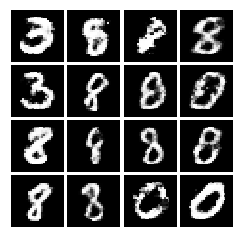

############################
Iter: 190000
D loss: 0.4704
G_loss: 3.037


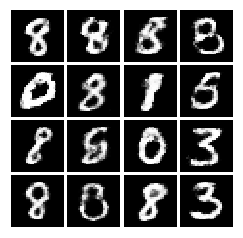

############################
Iter: 191000
D loss: 0.6086
G_loss: 2.763


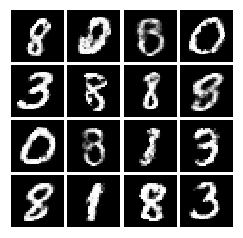

############################
Iter: 192000
D loss: 0.4527
G_loss: 2.688


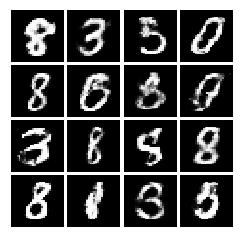

############################
Iter: 193000
D loss: 0.4476
G_loss: 2.966


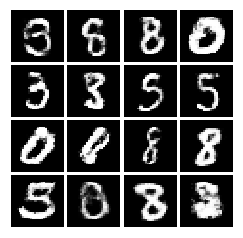

############################
Iter: 194000
D loss: 0.4472
G_loss: 2.979


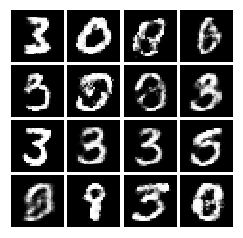

############################
Iter: 195000
D loss: 0.6551
G_loss: 2.771


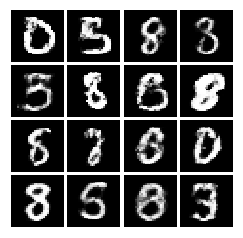

############################
Iter: 196000
D loss: 0.4156
G_loss: 3.125


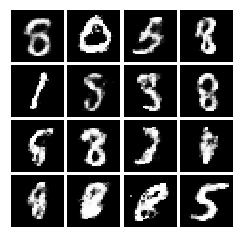

############################
Iter: 197000
D loss: 0.4369
G_loss: 2.47


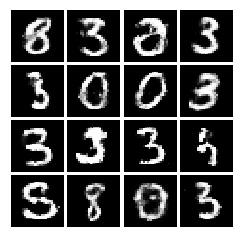

############################
Iter: 198000
D loss: 0.5057
G_loss: 2.826


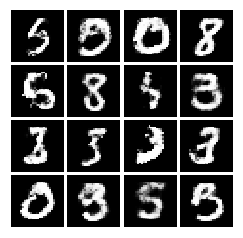

############################
Iter: 199000
D loss: 0.4683
G_loss: 3.147


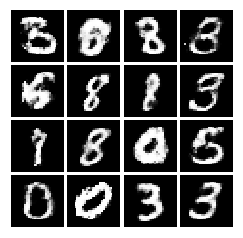

############################
Iter: 200000
D loss: 0.4864
G_loss: 2.237


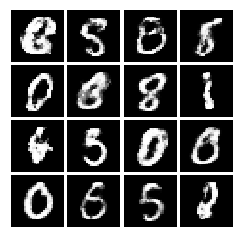

############################
Iter: 201000
D loss: 0.4888
G_loss: 2.688


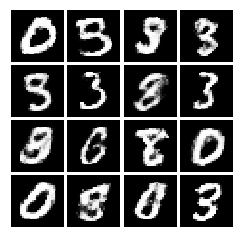

############################
Iter: 202000
D loss: 0.4779
G_loss: 2.461


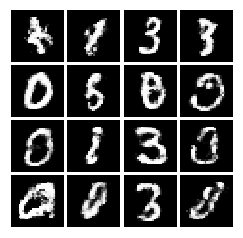

############################
Iter: 203000
D loss: 0.4839
G_loss: 2.192


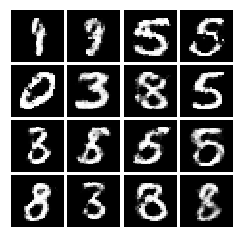

############################
Iter: 204000
D loss: 0.3288
G_loss: 2.549


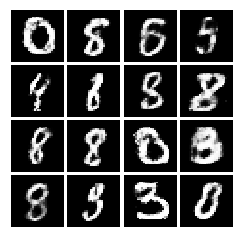

############################
Iter: 205000
D loss: 0.5005
G_loss: 2.95


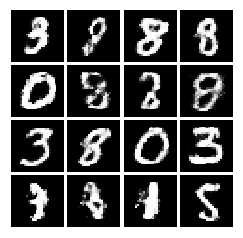

############################
Iter: 206000
D loss: 0.4928
G_loss: 2.73


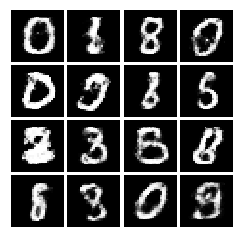

############################
Iter: 207000
D loss: 0.4945
G_loss: 2.539


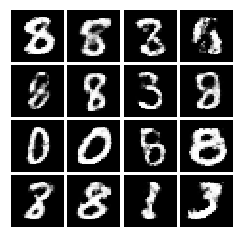

############################
Iter: 208000
D loss: 0.4247
G_loss: 2.409


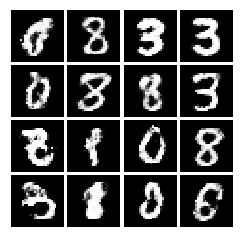

############################
Iter: 209000
D loss: 0.4079
G_loss: 2.189


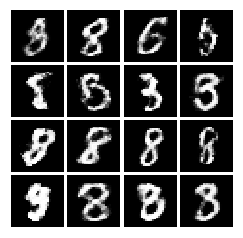

############################
Iter: 210000
D loss: 0.5191
G_loss: 2.51


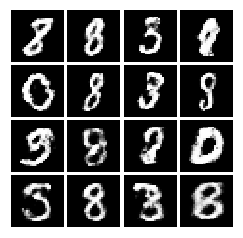

############################
Iter: 211000
D loss: 0.485
G_loss: 2.666


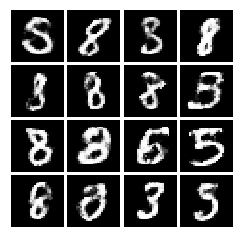

############################
Iter: 212000
D loss: 0.3829
G_loss: 2.819


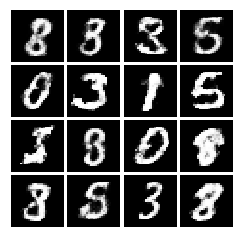

############################
Iter: 213000
D loss: 0.511
G_loss: 2.729


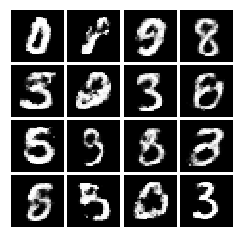

############################
Iter: 214000
D loss: 0.5129
G_loss: 2.937


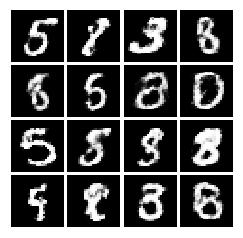

############################
Iter: 215000
D loss: 0.526
G_loss: 3.041


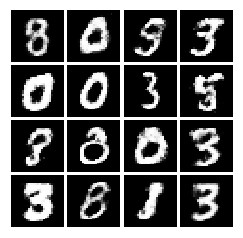

############################
Iter: 216000
D loss: 0.5149
G_loss: 2.603


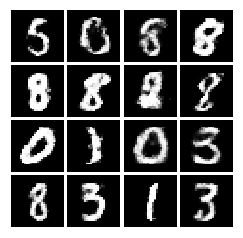

############################
Iter: 217000
D loss: 0.5398
G_loss: 2.921


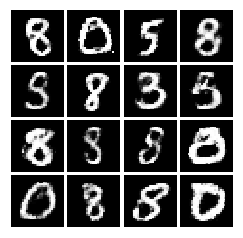

############################
Iter: 218000
D loss: 0.5087
G_loss: 2.952


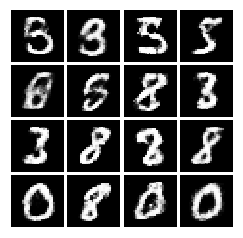

############################
Iter: 219000
D loss: 0.5603
G_loss: 2.371


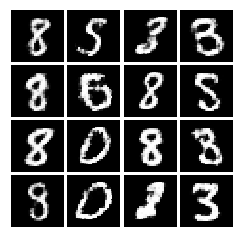

############################
Iter: 220000
D loss: 0.4945
G_loss: 2.288


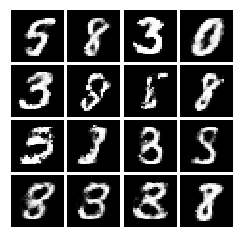

############################
Iter: 221000
D loss: 0.5426
G_loss: 2.772


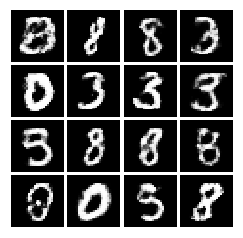

############################
Iter: 222000
D loss: 0.5173
G_loss: 2.94


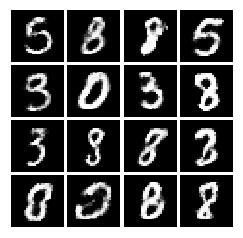

############################
Iter: 223000
D loss: 0.6313
G_loss: 2.908


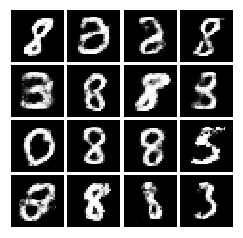

############################
Iter: 224000
D loss: 0.502
G_loss: 2.716


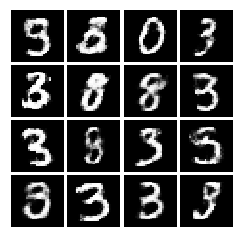

############################
Iter: 225000
D loss: 0.4238
G_loss: 2.965


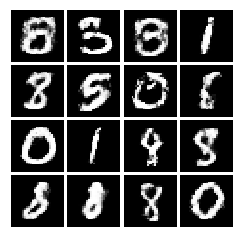

############################
Iter: 226000
D loss: 0.5291
G_loss: 2.771


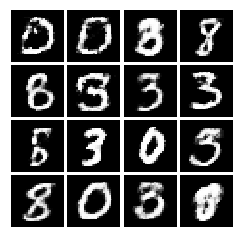

############################
Iter: 227000
D loss: 0.4714
G_loss: 3.234


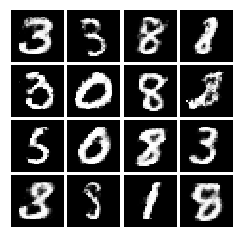

############################
Iter: 228000
D loss: 0.4558
G_loss: 2.747


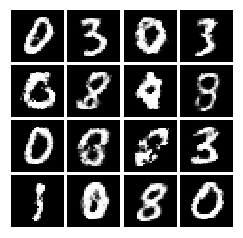

############################
Iter: 229000
D loss: 0.5849
G_loss: 3.191


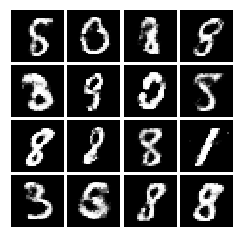

############################
Iter: 230000
D loss: 0.5001
G_loss: 2.734


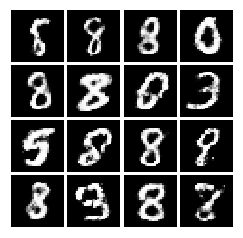

############################
Iter: 231000
D loss: 0.5166
G_loss: 2.704


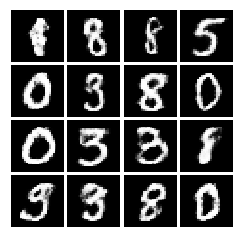

############################
Iter: 232000
D loss: 0.4786
G_loss: 2.519


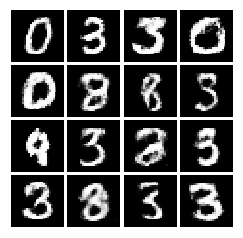

############################
Iter: 233000
D loss: 0.4124
G_loss: 3.146


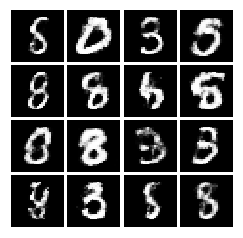

############################
Iter: 234000
D loss: 0.415
G_loss: 2.513


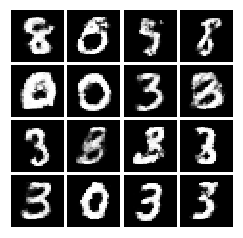

############################
Iter: 235000
D loss: 0.5027
G_loss: 2.597


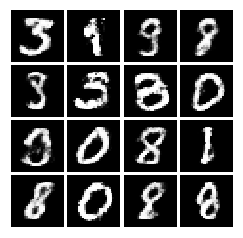

############################
Iter: 236000
D loss: 0.4629
G_loss: 3.088


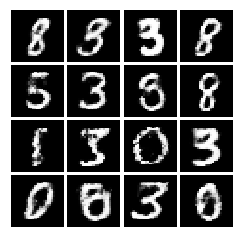

############################
Iter: 237000
D loss: 0.474
G_loss: 3.203


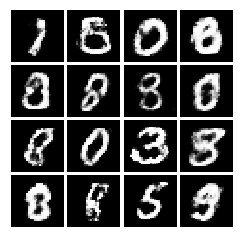

############################
Iter: 238000
D loss: 0.5301
G_loss: 2.65


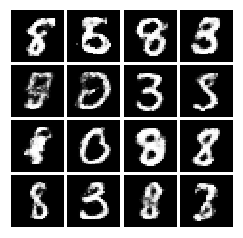

############################
Iter: 239000
D loss: 0.4457
G_loss: 2.688


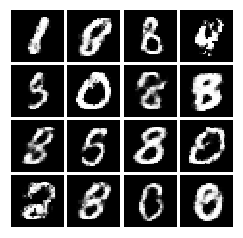

############################
Iter: 240000
D loss: 0.4699
G_loss: 2.655


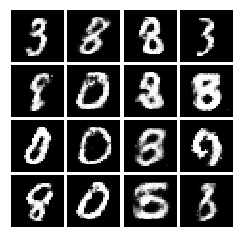

############################
Iter: 241000
D loss: 0.6002
G_loss: 2.724


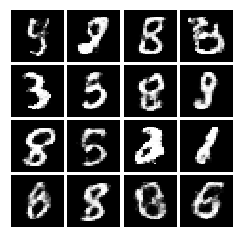

############################
Iter: 242000
D loss: 0.4085
G_loss: 2.437


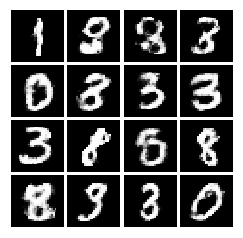

############################
Iter: 243000
D loss: 0.5115
G_loss: 2.646


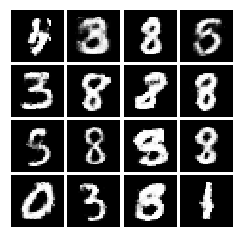

############################
Iter: 244000
D loss: 0.5128
G_loss: 2.812


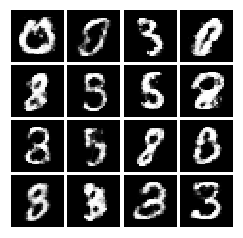

############################
Iter: 245000
D loss: 0.4305
G_loss: 2.467


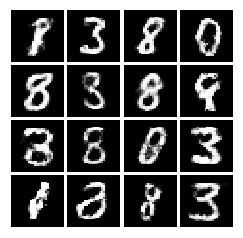

############################
Iter: 246000
D loss: 0.4968
G_loss: 3.189


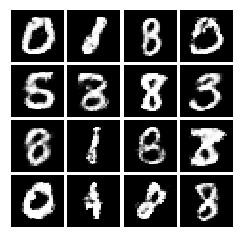

############################
Iter: 247000
D loss: 0.4559
G_loss: 2.603


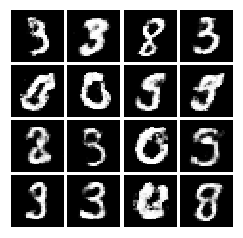

############################
Iter: 248000
D loss: 0.5124
G_loss: 2.541


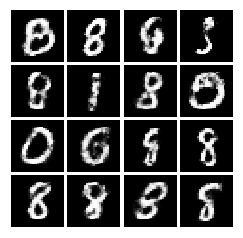

############################
Iter: 249000
D loss: 0.4941
G_loss: 2.454


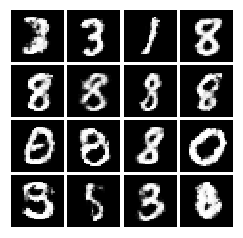

############################
Iter: 250000
D loss: 0.4632
G_loss: 2.573


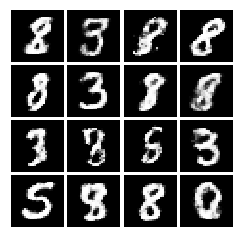

############################
Iter: 251000
D loss: 0.4488
G_loss: 2.618


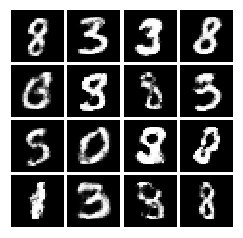

############################
Iter: 252000
D loss: 0.609
G_loss: 2.934


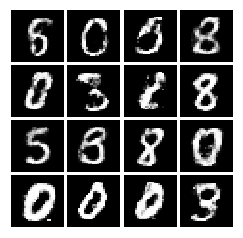

############################
Iter: 253000
D loss: 0.3685
G_loss: 3.211


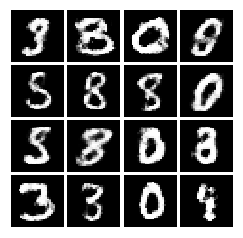

############################
Iter: 254000
D loss: 0.4649
G_loss: 3.138


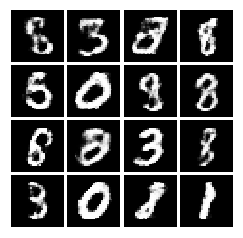

############################
Iter: 255000
D loss: 0.4668
G_loss: 2.698


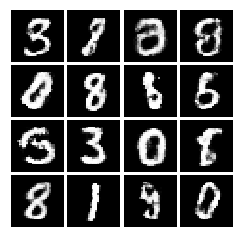

############################
Iter: 256000
D loss: 0.4517
G_loss: 2.938


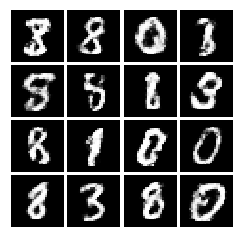

############################
Iter: 257000
D loss: 0.4516
G_loss: 2.752


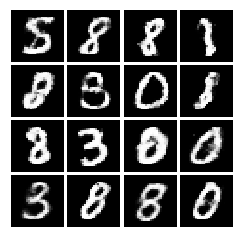

############################
Iter: 258000
D loss: 0.4821
G_loss: 3.219


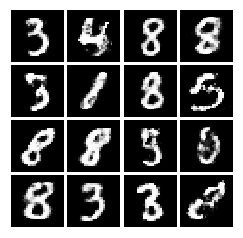

############################
Iter: 259000
D loss: 0.4091
G_loss: 2.772


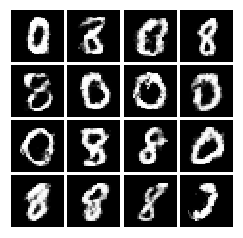

############################
Iter: 260000
D loss: 0.5756
G_loss: 3.188


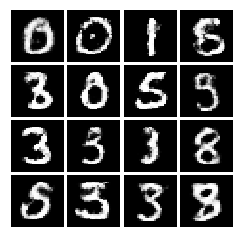

############################
Iter: 261000
D loss: 0.3968
G_loss: 2.775


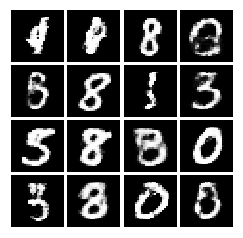

############################
Iter: 262000
D loss: 0.4896
G_loss: 3.031


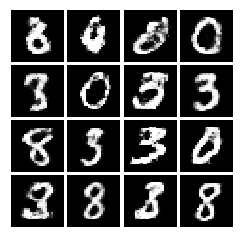

############################
Iter: 263000
D loss: 0.3558
G_loss: 2.779


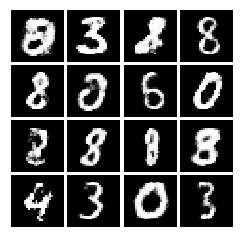

############################
Iter: 264000
D loss: 0.5777
G_loss: 3.105


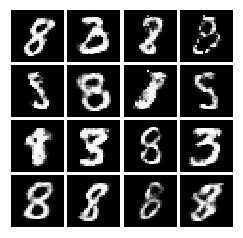

############################
Iter: 265000
D loss: 0.5001
G_loss: 2.712


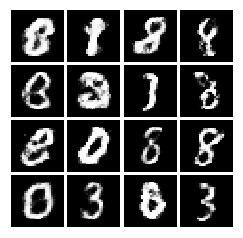

############################
Iter: 266000
D loss: 0.4652
G_loss: 3.104


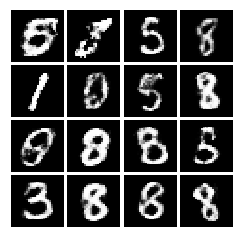

############################
Iter: 267000
D loss: 0.4771
G_loss: 3.315


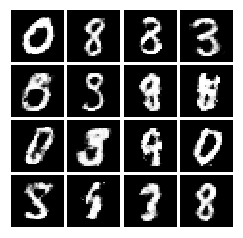

############################
Iter: 268000
D loss: 0.4574
G_loss: 2.966


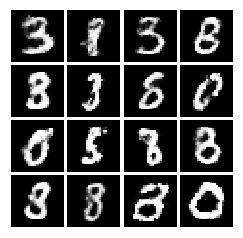

############################
Iter: 269000
D loss: 0.4647
G_loss: 3.044


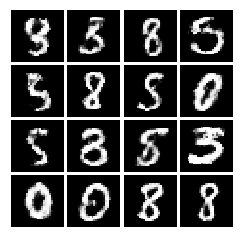

############################
Iter: 270000
D loss: 0.5263
G_loss: 3.047


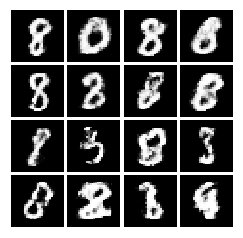

############################
Iter: 271000
D loss: 0.5331
G_loss: 2.534


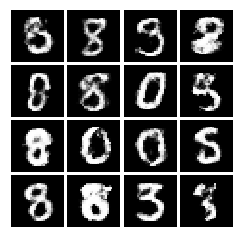

############################
Iter: 272000
D loss: 0.4499
G_loss: 3.696


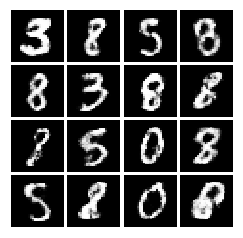

############################
Iter: 273000
D loss: 0.4749
G_loss: 2.615


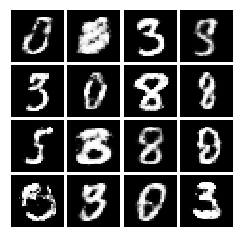

############################
Iter: 274000
D loss: 0.4677
G_loss: 2.555


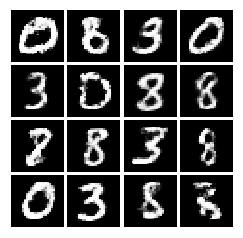

############################
Iter: 275000
D loss: 0.4024
G_loss: 3.153


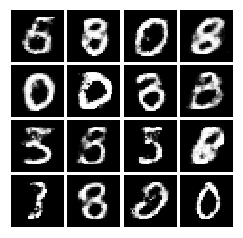

############################
Iter: 276000
D loss: 0.4448
G_loss: 2.543


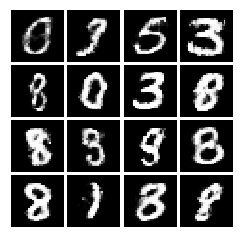

############################
Iter: 277000
D loss: 0.447
G_loss: 2.58


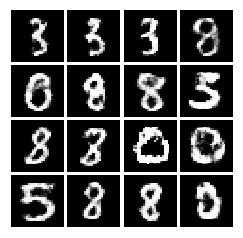

############################
Iter: 278000
D loss: 0.4419
G_loss: 3.251


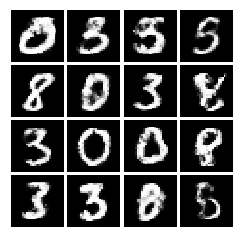

############################
Iter: 279000
D loss: 0.4177
G_loss: 2.945


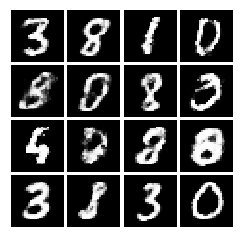

############################
Iter: 280000
D loss: 0.5382
G_loss: 2.761


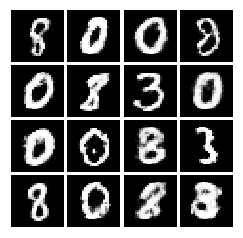

############################
Iter: 281000
D loss: 0.4561
G_loss: 3.164


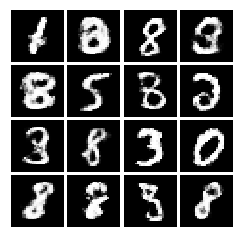

############################
Iter: 282000
D loss: 0.4622
G_loss: 2.989


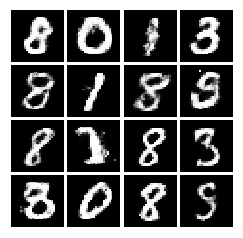

############################
Iter: 283000
D loss: 0.437
G_loss: 2.805


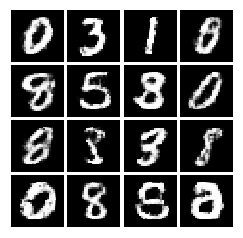

############################
Iter: 284000
D loss: 0.4607
G_loss: 3.17


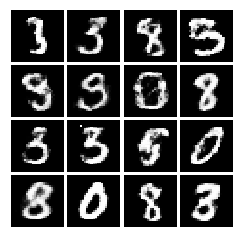

############################
Iter: 285000
D loss: 0.5906
G_loss: 2.486


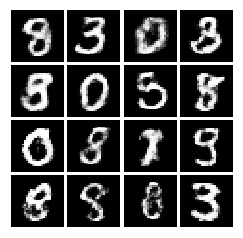

############################
Iter: 286000
D loss: 0.4547
G_loss: 2.683


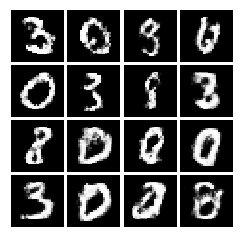

############################
Iter: 287000
D loss: 0.3998
G_loss: 2.663


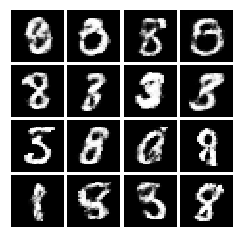

############################
Iter: 288000
D loss: 0.4045
G_loss: 2.691


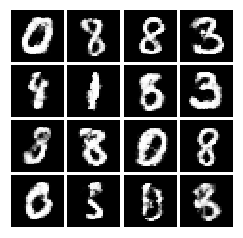

############################
Iter: 289000
D loss: 0.5406
G_loss: 2.559


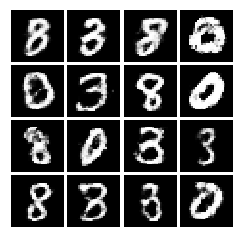

############################
Iter: 290000
D loss: 0.4283
G_loss: 3.063


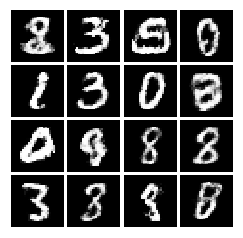

############################
Iter: 291000
D loss: 0.5132
G_loss: 3.184


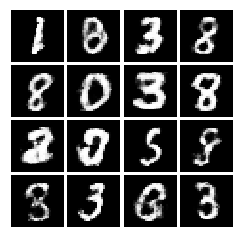

############################
Iter: 292000
D loss: 0.4228
G_loss: 3.146


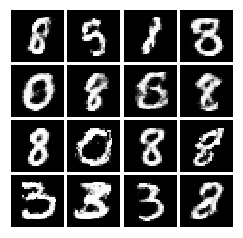

############################
Iter: 293000
D loss: 0.4777
G_loss: 2.903


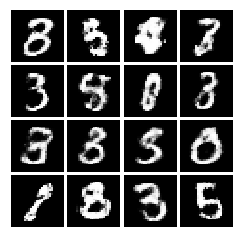

############################
Iter: 294000
D loss: 0.415
G_loss: 2.911


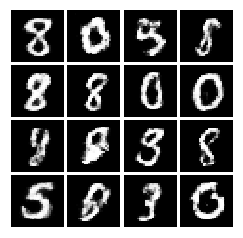

############################
Iter: 295000
D loss: 0.5555
G_loss: 2.663


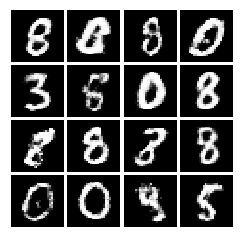

############################
Iter: 296000
D loss: 0.5225
G_loss: 2.974


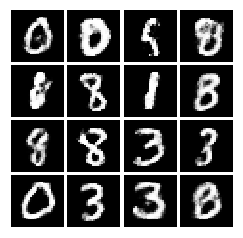

############################
Iter: 297000
D loss: 0.4619
G_loss: 2.665


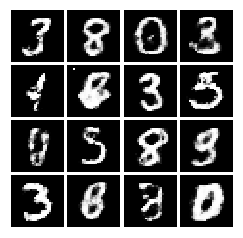

############################
Iter: 298000
D loss: 0.4615
G_loss: 2.726


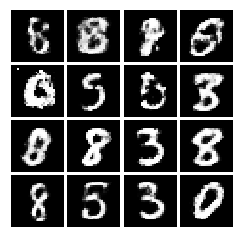

############################
Iter: 299000
D loss: 0.3508
G_loss: 3.266


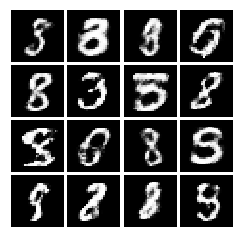

############################
Iter: 300000
D loss: 0.3503
G_loss: 2.915


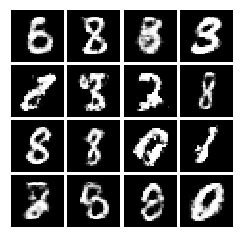

############################
Iter: 301000
D loss: 0.411
G_loss: 3.003


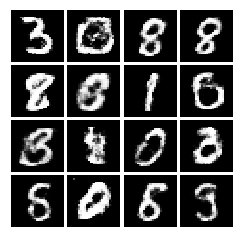

############################
Iter: 302000
D loss: 0.4183
G_loss: 2.606


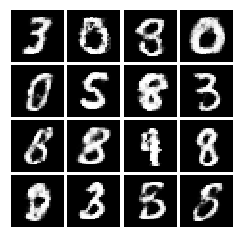

############################
Iter: 303000
D loss: 0.4535
G_loss: 2.787


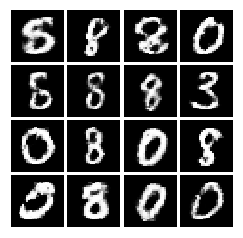

############################
Iter: 304000
D loss: 0.5106
G_loss: 2.904


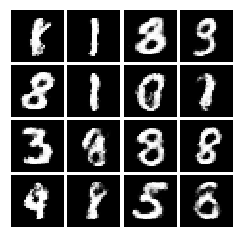

############################
Iter: 305000
D loss: 0.6062
G_loss: 2.964


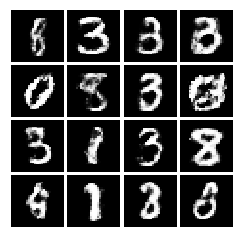

############################
Iter: 306000
D loss: 0.4269
G_loss: 2.728


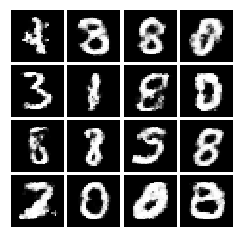

############################
Iter: 307000
D loss: 0.491
G_loss: 2.612


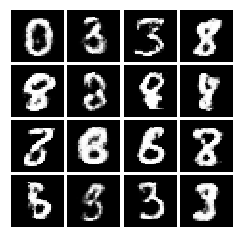

############################
Iter: 308000
D loss: 0.5022
G_loss: 3.289


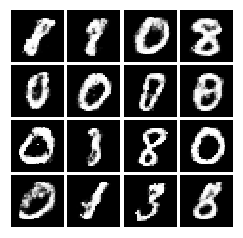

############################
Iter: 309000
D loss: 0.4476
G_loss: 2.613


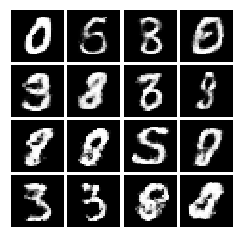

############################
Iter: 310000
D loss: 0.564
G_loss: 2.957


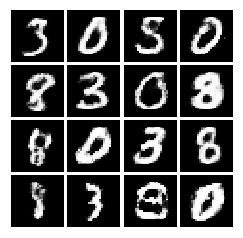

############################
Iter: 311000
D loss: 0.4191
G_loss: 2.744


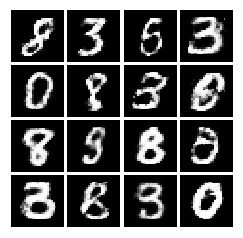

############################
Iter: 312000
D loss: 0.4633
G_loss: 2.886


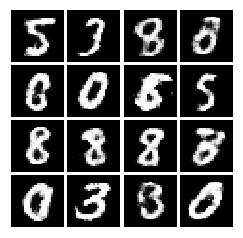

############################
Iter: 313000
D loss: 0.58
G_loss: 2.538


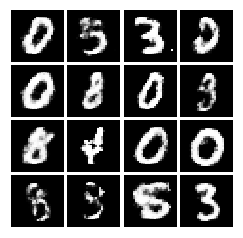

############################
Iter: 314000
D loss: 0.6497
G_loss: 2.454


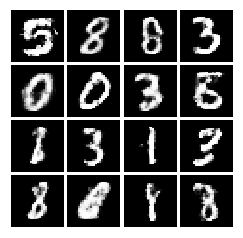

############################
Iter: 315000
D loss: 0.4908
G_loss: 3.275


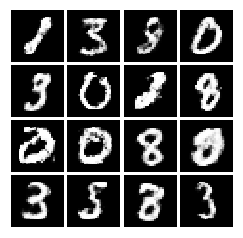

############################
Iter: 316000
D loss: 0.5353
G_loss: 3.23


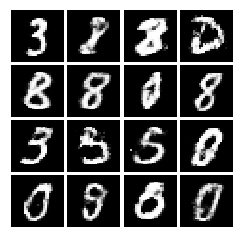

############################
Iter: 317000
D loss: 0.3848
G_loss: 3.12


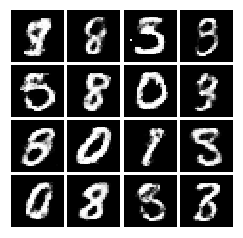

############################
Iter: 318000
D loss: 0.3984
G_loss: 2.787


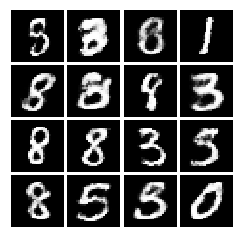

############################
Iter: 319000
D loss: 0.3927
G_loss: 2.705


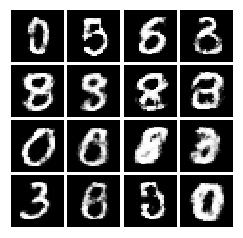

############################
Iter: 320000
D loss: 0.4105
G_loss: 2.7


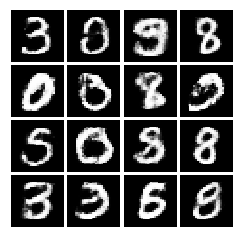

############################
Iter: 321000
D loss: 0.4574
G_loss: 2.887


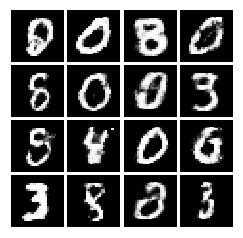

############################
Iter: 322000
D loss: 0.5117
G_loss: 2.623


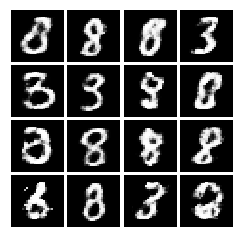

############################
Iter: 323000
D loss: 0.3871
G_loss: 2.809


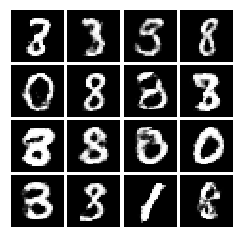

############################
Iter: 324000
D loss: 0.374
G_loss: 2.547


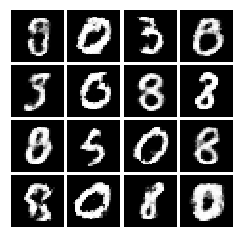

############################
Iter: 325000
D loss: 0.4314
G_loss: 2.81


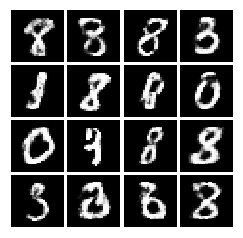

############################
Iter: 326000
D loss: 0.4076
G_loss: 2.902


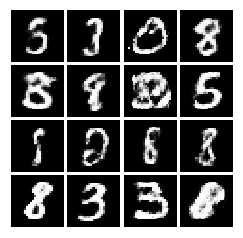

############################
Iter: 327000
D loss: 0.5208
G_loss: 2.925


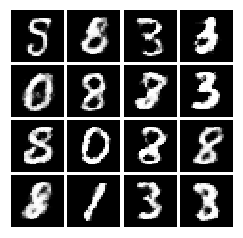

############################
Iter: 328000
D loss: 0.3888
G_loss: 3.166


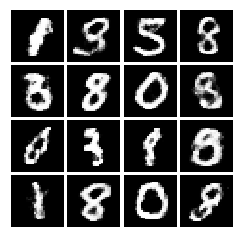

############################
Iter: 329000
D loss: 0.3768
G_loss: 2.962


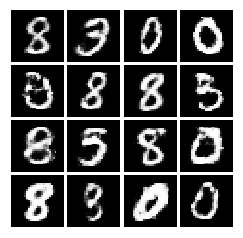

############################
Iter: 330000
D loss: 0.3915
G_loss: 2.97


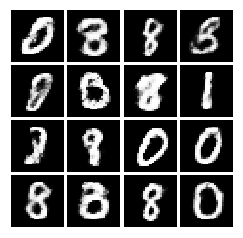

############################
Iter: 331000
D loss: 0.3847
G_loss: 2.89


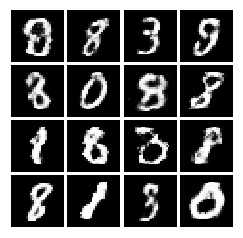

############################
Iter: 332000
D loss: 0.389
G_loss: 2.812


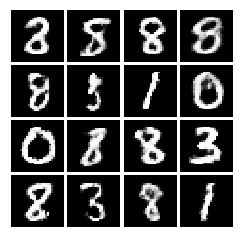

############################
Iter: 333000
D loss: 0.4167
G_loss: 2.944


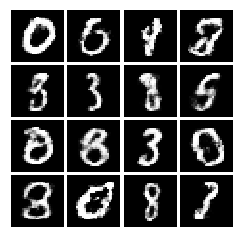

############################
Iter: 334000
D loss: 0.5372
G_loss: 2.627


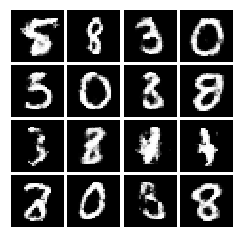

############################
Iter: 335000
D loss: 0.387
G_loss: 2.899


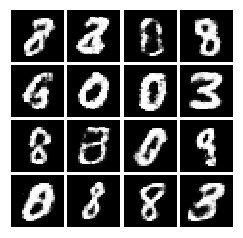

############################
Iter: 336000
D loss: 0.501
G_loss: 2.889


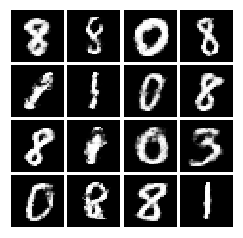

############################
Iter: 337000
D loss: 0.4047
G_loss: 3.239


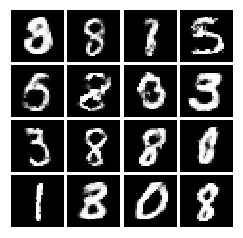

############################
Iter: 338000
D loss: 0.5424
G_loss: 3.085


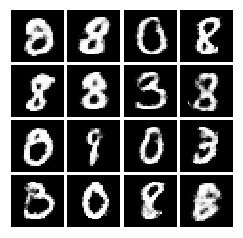

############################
Iter: 339000
D loss: 0.5262
G_loss: 2.689


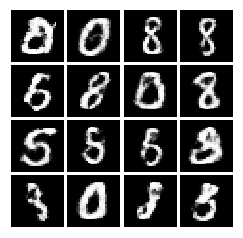

############################
Iter: 340000
D loss: 0.5908
G_loss: 2.846


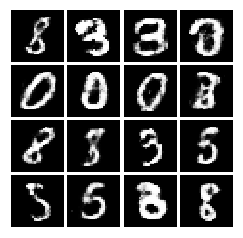

############################
Iter: 341000
D loss: 0.425
G_loss: 2.774


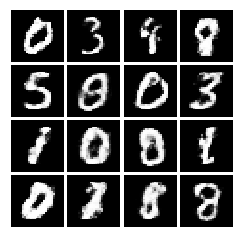

############################
Iter: 342000
D loss: 0.4557
G_loss: 2.791


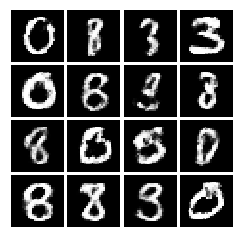

############################
Iter: 343000
D loss: 0.4435
G_loss: 3.212


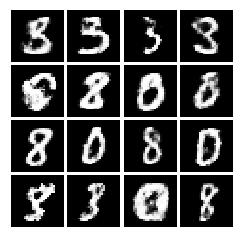

############################
Iter: 344000
D loss: 0.5387
G_loss: 3.031


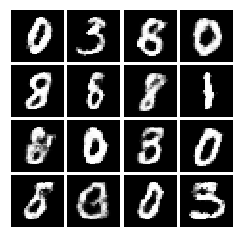

############################
Iter: 345000
D loss: 0.4231
G_loss: 3.266


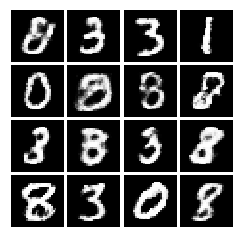

############################
Iter: 346000
D loss: 0.4523
G_loss: 2.717


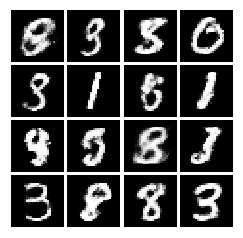

############################
Iter: 347000
D loss: 0.4385
G_loss: 3.162


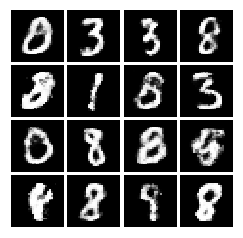

############################
Iter: 348000
D loss: 0.4541
G_loss: 2.59


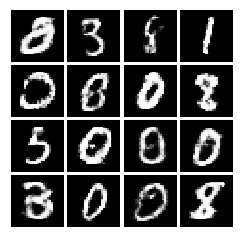

############################
Iter: 349000
D loss: 0.5583
G_loss: 2.692


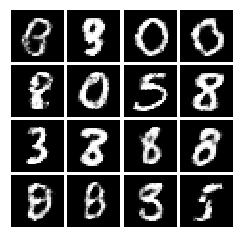

############################
Iter: 350000
D loss: 0.517
G_loss: 2.94


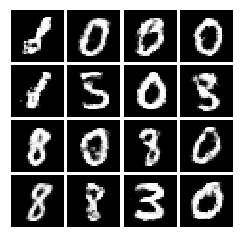

############################
Iter: 351000
D loss: 0.4495
G_loss: 2.829


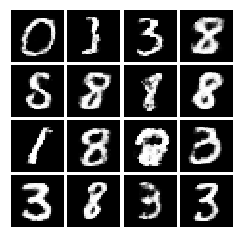

############################
Iter: 352000
D loss: 0.4818
G_loss: 2.748


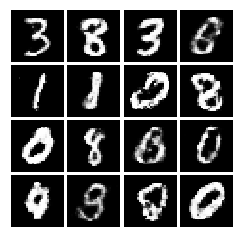

############################
Iter: 353000
D loss: 0.4367
G_loss: 3.071


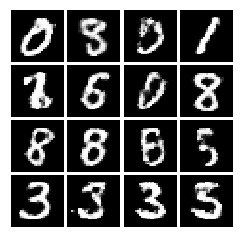

############################
Iter: 354000
D loss: 0.5824
G_loss: 2.894


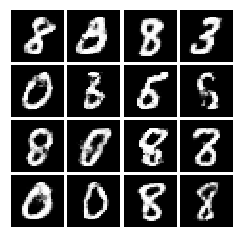

############################
Iter: 355000
D loss: 0.5506
G_loss: 2.495


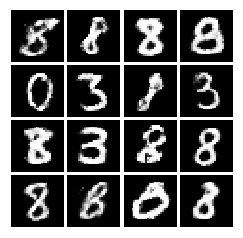

############################
Iter: 356000
D loss: 0.4372
G_loss: 2.894


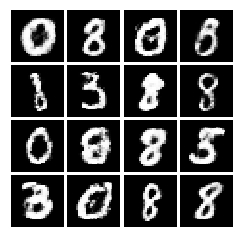

############################
Iter: 357000
D loss: 0.5011
G_loss: 2.493


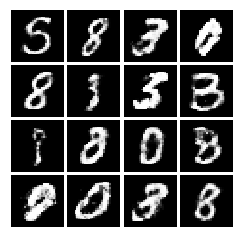

############################
Iter: 358000
D loss: 0.5189
G_loss: 3.028


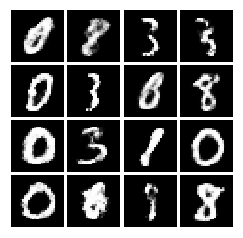

############################
Iter: 359000
D loss: 0.571
G_loss: 3.119


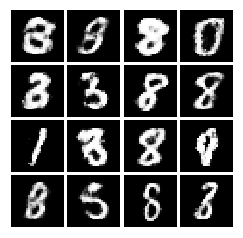

############################
Iter: 360000
D loss: 0.4623
G_loss: 2.926


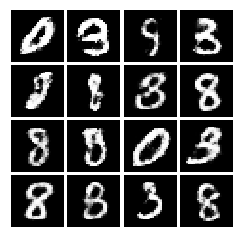

############################
Iter: 361000
D loss: 0.5184
G_loss: 3.658


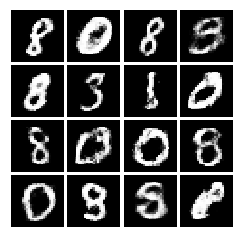

############################
Iter: 362000
D loss: 0.4951
G_loss: 2.687


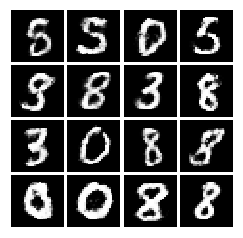

############################
Iter: 363000
D loss: 0.3248
G_loss: 2.727


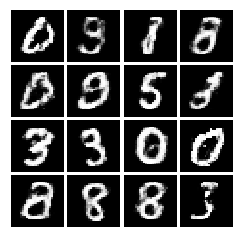

############################
Iter: 364000
D loss: 0.4108
G_loss: 3.025


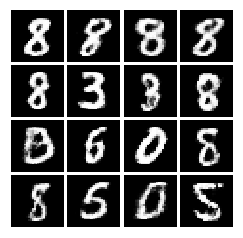

############################
Iter: 365000
D loss: 0.5024
G_loss: 2.941


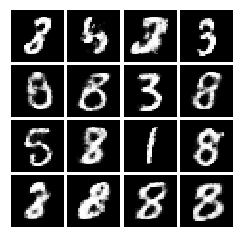

############################
Iter: 366000
D loss: 0.2933
G_loss: 3.055


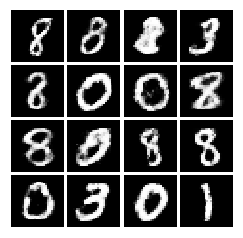

############################
Iter: 367000
D loss: 0.3935
G_loss: 2.533


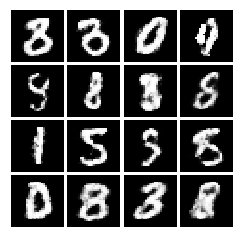

############################
Iter: 368000
D loss: 0.5643
G_loss: 2.581


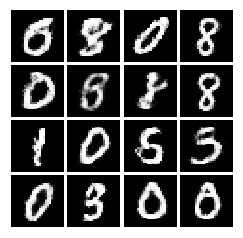

############################
Iter: 369000
D loss: 0.3831
G_loss: 2.698


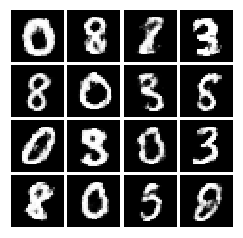

############################
Iter: 370000
D loss: 0.3681
G_loss: 2.857


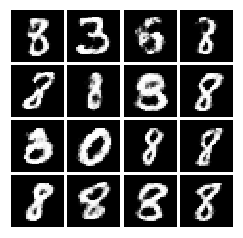

############################
Iter: 371000
D loss: 0.4252
G_loss: 3.447


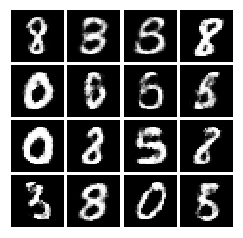

############################
Iter: 372000
D loss: 0.4581
G_loss: 3.005


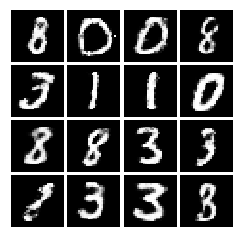

############################
Iter: 373000
D loss: 0.4879
G_loss: 3.014


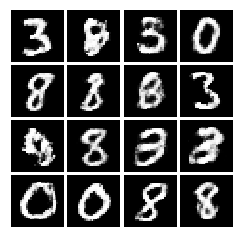

############################
Iter: 374000
D loss: 0.4307
G_loss: 2.894


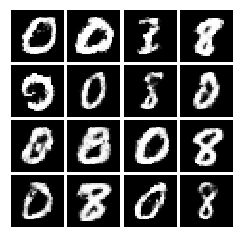

############################
Iter: 375000
D loss: 0.4708
G_loss: 2.764


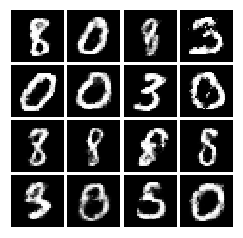

############################
Iter: 376000
D loss: 0.4162
G_loss: 2.915


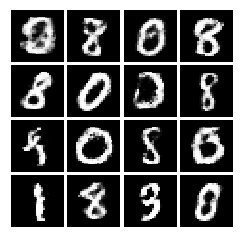

############################
Iter: 377000
D loss: 0.432
G_loss: 2.831


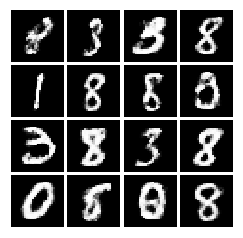

############################
Iter: 378000
D loss: 0.4611
G_loss: 3.078


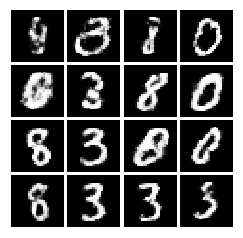

############################
Iter: 379000
D loss: 0.5893
G_loss: 3.199


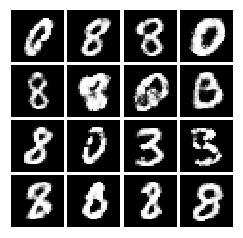

############################
Iter: 380000
D loss: 0.4588
G_loss: 3.224


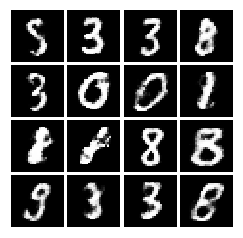

############################
Iter: 381000
D loss: 0.4041
G_loss: 2.978


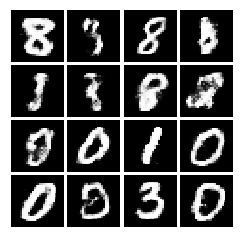

############################
Iter: 382000
D loss: 0.4188
G_loss: 2.536


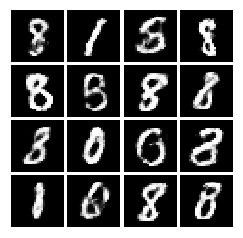

############################
Iter: 383000
D loss: 0.4001
G_loss: 2.917


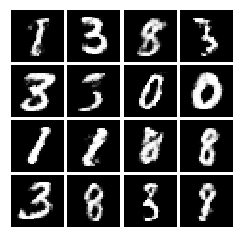

############################
Iter: 384000
D loss: 0.3968
G_loss: 3.175


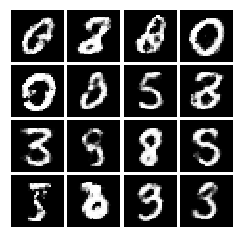

############################
Iter: 385000
D loss: 0.4713
G_loss: 2.987


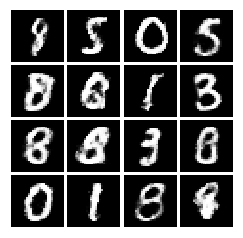

############################
Iter: 386000
D loss: 0.4033
G_loss: 2.895


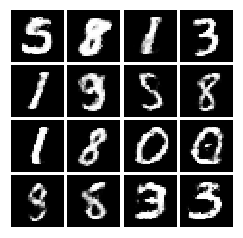

############################
Iter: 387000
D loss: 0.5151
G_loss: 3.284


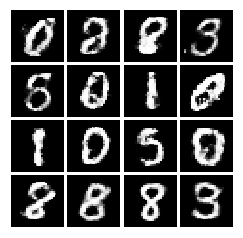

############################
Iter: 388000
D loss: 0.404
G_loss: 2.906


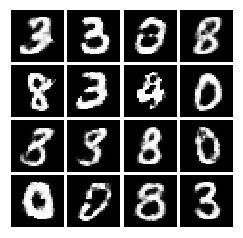

############################
Iter: 389000
D loss: 0.4428
G_loss: 2.841


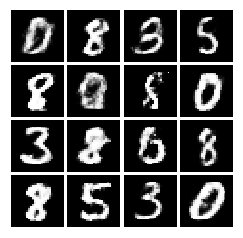

############################
Iter: 390000
D loss: 0.7377
G_loss: 2.821


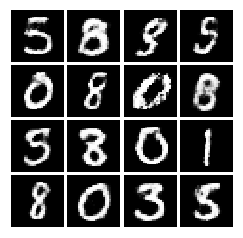

############################
Iter: 391000
D loss: 0.6026
G_loss: 2.988


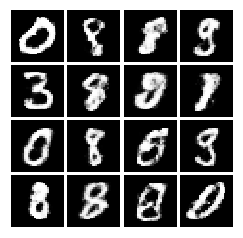

############################
Iter: 392000
D loss: 0.4128
G_loss: 2.756


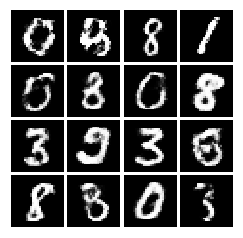

############################
Iter: 393000
D loss: 0.4284
G_loss: 2.925


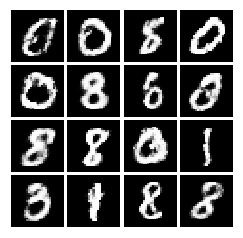

############################
Iter: 394000
D loss: 0.552
G_loss: 3.016


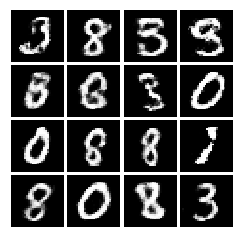

############################
Iter: 395000
D loss: 0.485
G_loss: 3.268


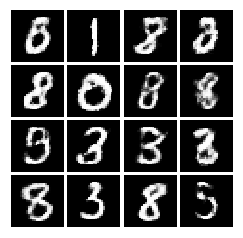

############################
Iter: 396000
D loss: 0.5755
G_loss: 3.418


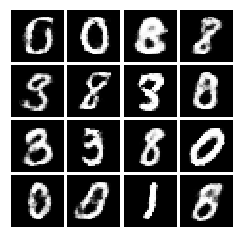

############################
Iter: 397000
D loss: 0.3381
G_loss: 3.266


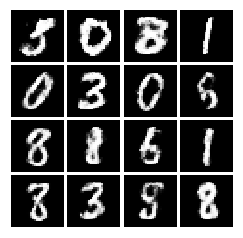

############################
Iter: 398000
D loss: 0.4922
G_loss: 2.877


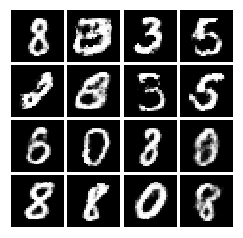

############################
Iter: 399000
D loss: 0.4378
G_loss: 3.132


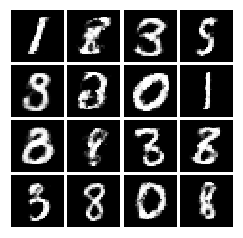

############################
Iter: 400000
D loss: 0.3431
G_loss: 2.943


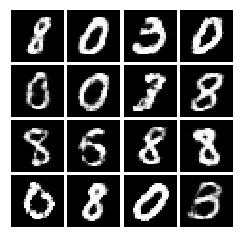

############################
Iter: 401000
D loss: 0.4286
G_loss: 2.996


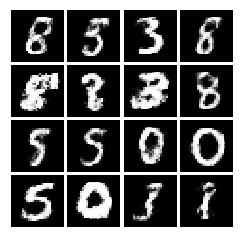

############################
Iter: 402000
D loss: 0.4443
G_loss: 2.993


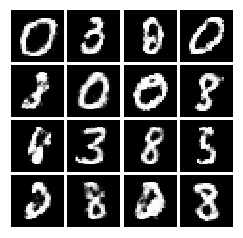

############################
Iter: 403000
D loss: 0.5205
G_loss: 3.258


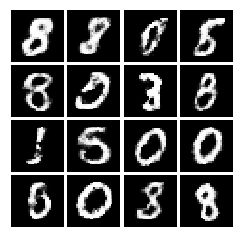

############################
Iter: 404000
D loss: 0.4897
G_loss: 3.415


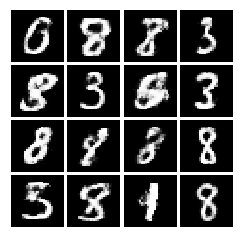

############################
Iter: 405000
D loss: 0.3608
G_loss: 3.289


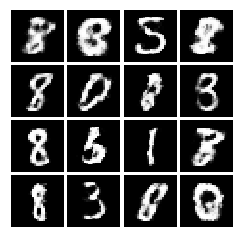

############################
Iter: 406000
D loss: 0.4795
G_loss: 2.875


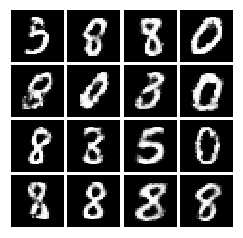

############################
Iter: 407000
D loss: 0.4948
G_loss: 2.987


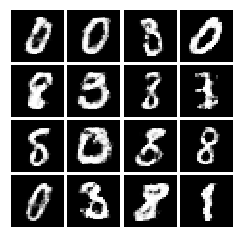

############################
Iter: 408000
D loss: 0.4229
G_loss: 3.101


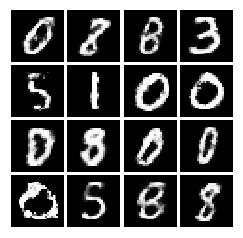

############################
Iter: 409000
D loss: 0.5782
G_loss: 2.81


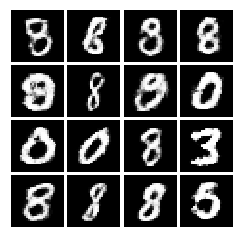

############################
Iter: 410000
D loss: 0.4495
G_loss: 3.001


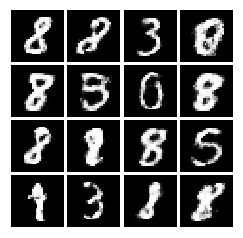

############################
Iter: 411000
D loss: 0.4223
G_loss: 2.805


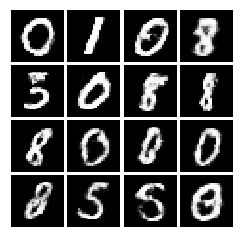

############################
Iter: 412000
D loss: 0.437
G_loss: 3.36


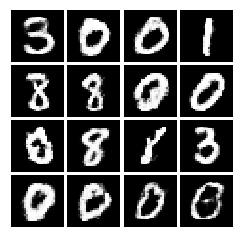

############################
Iter: 413000
D loss: 0.4511
G_loss: 3.206


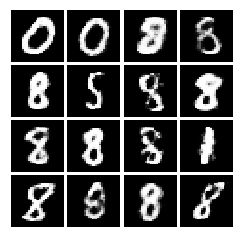

############################
Iter: 414000
D loss: 0.4505
G_loss: 3.37


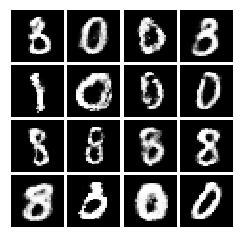

############################
Iter: 415000
D loss: 0.5785
G_loss: 2.938


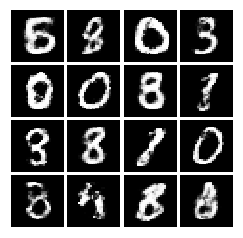

############################
Iter: 416000
D loss: 0.3792
G_loss: 3.159


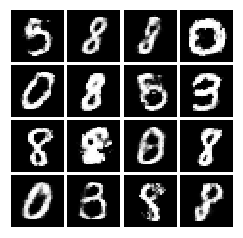

############################
Iter: 417000
D loss: 0.4376
G_loss: 3.184


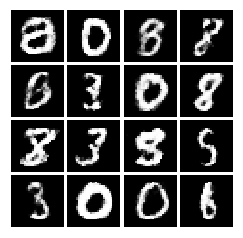

############################
Iter: 418000
D loss: 0.4873
G_loss: 3.255


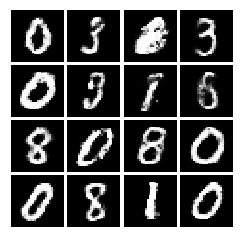

############################
Iter: 419000
D loss: 0.3907
G_loss: 3.163


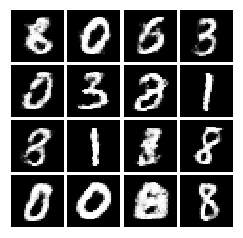

############################
Iter: 420000
D loss: 0.4744
G_loss: 3.391


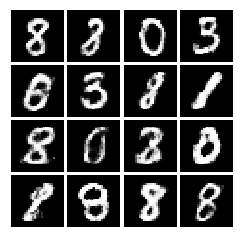

############################
Iter: 421000
D loss: 0.3597
G_loss: 3.12


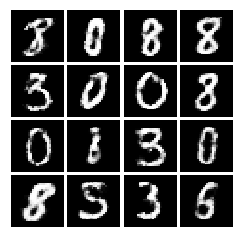

############################
Iter: 422000
D loss: 0.4638
G_loss: 3.296


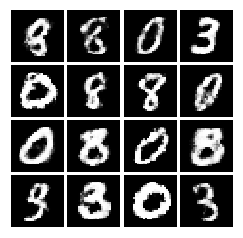

############################
Iter: 423000
D loss: 0.4325
G_loss: 3.446


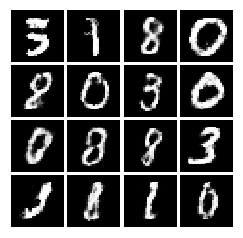

############################
Iter: 424000
D loss: 0.4389
G_loss: 3.045


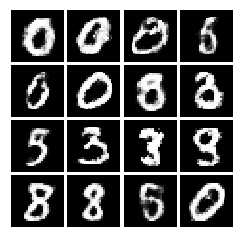

############################
Iter: 425000
D loss: 0.465
G_loss: 3.301


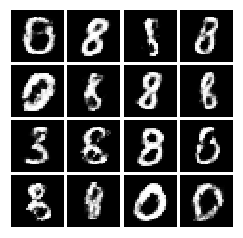

############################
Iter: 426000
D loss: 0.4694
G_loss: 2.872


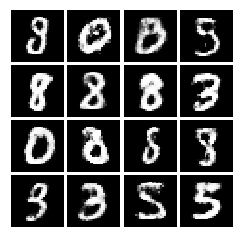

############################
Iter: 427000
D loss: 0.4886
G_loss: 3.161


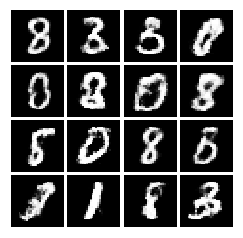

############################
Iter: 428000
D loss: 0.4186
G_loss: 2.979


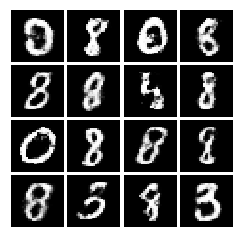

############################
Iter: 429000
D loss: 0.4339
G_loss: 3.006


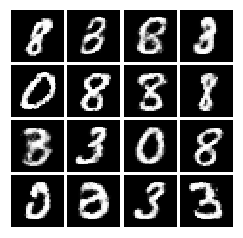

############################
Iter: 430000
D loss: 0.4169
G_loss: 3.122


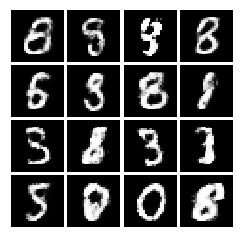

############################
Iter: 431000
D loss: 0.488
G_loss: 3.499


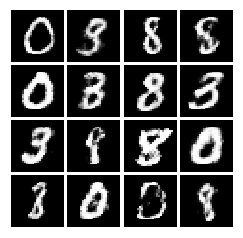

############################
Iter: 432000
D loss: 0.5457
G_loss: 3.378


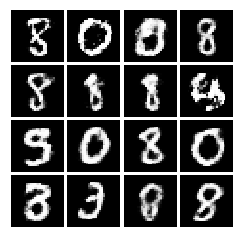

############################
Iter: 433000
D loss: 0.479
G_loss: 3.028


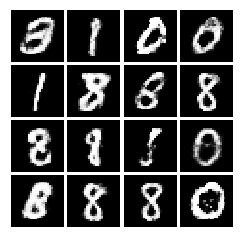

############################
Iter: 434000
D loss: 0.5171
G_loss: 2.639


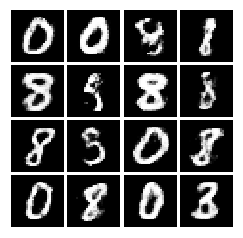

############################
Iter: 435000
D loss: 0.449
G_loss: 3.366


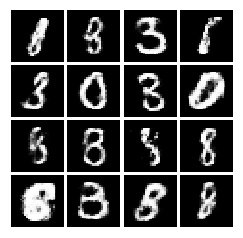

############################
Iter: 436000
D loss: 0.4316
G_loss: 3.178


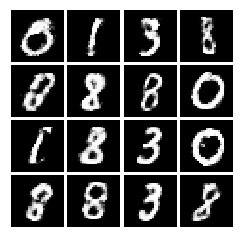

############################
Iter: 437000
D loss: 0.3582
G_loss: 2.541


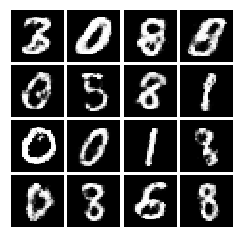

############################
Iter: 438000
D loss: 0.3691
G_loss: 2.829


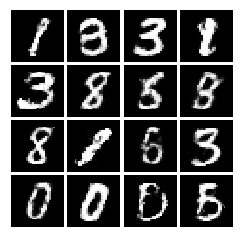

############################
Iter: 439000
D loss: 0.4714
G_loss: 3.341


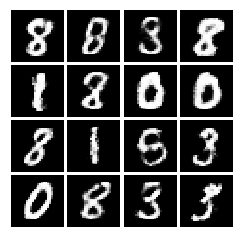

############################
Iter: 440000
D loss: 0.3905
G_loss: 3.331


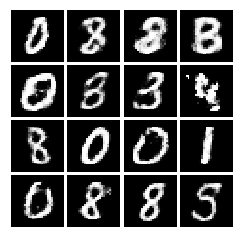

############################
Iter: 441000
D loss: 0.5056
G_loss: 2.754


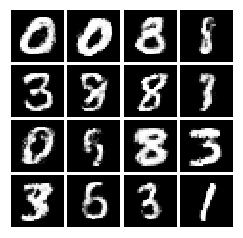

############################
Iter: 442000
D loss: 0.455
G_loss: 3.018


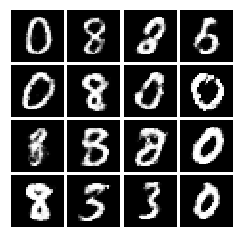

############################
Iter: 443000
D loss: 0.4936
G_loss: 2.896


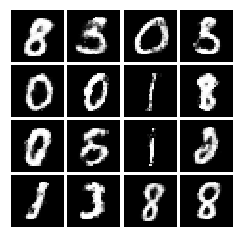

############################
Iter: 444000
D loss: 0.3545
G_loss: 2.645


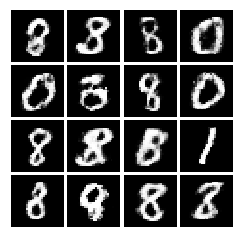

############################
Iter: 445000
D loss: 0.5497
G_loss: 3.138


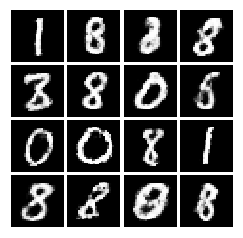

############################
Iter: 446000
D loss: 0.5027
G_loss: 3.103


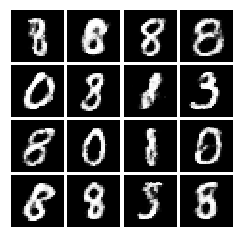

############################
Iter: 447000
D loss: 0.46
G_loss: 2.945


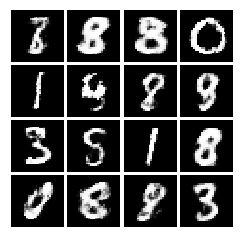

############################
Iter: 448000
D loss: 0.5032
G_loss: 3.62


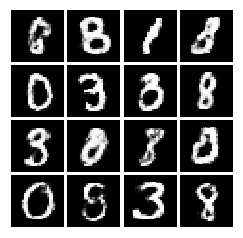

############################
Iter: 449000
D loss: 0.4899
G_loss: 3.192


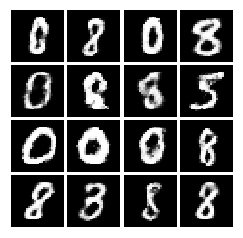

############################
Iter: 450000
D loss: 0.5614
G_loss: 3.39


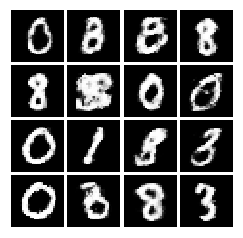

############################
Iter: 451000
D loss: 0.4271
G_loss: 3.059


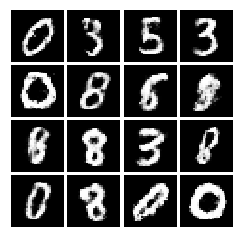

############################
Iter: 452000
D loss: 0.3426
G_loss: 3.034


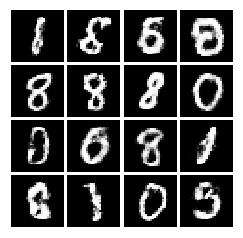

############################
Iter: 453000
D loss: 0.5333
G_loss: 3.096


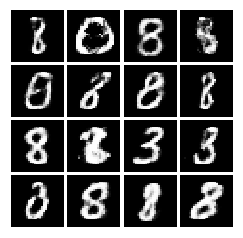

############################
Iter: 454000
D loss: 0.4035
G_loss: 3.569


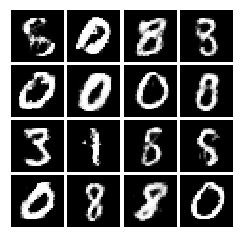

############################
Iter: 455000
D loss: 0.464
G_loss: 3.481


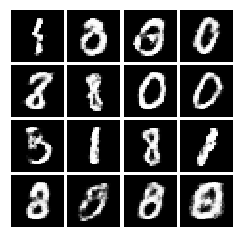

############################
Iter: 456000
D loss: 0.4934
G_loss: 3.249


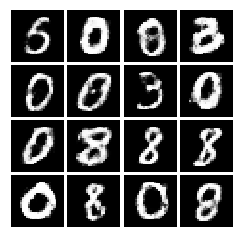

############################
Iter: 457000
D loss: 0.4246
G_loss: 3.04


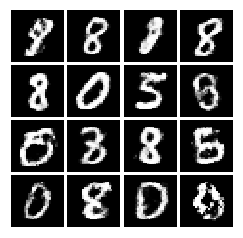

############################
Iter: 458000
D loss: 0.4257
G_loss: 3.099


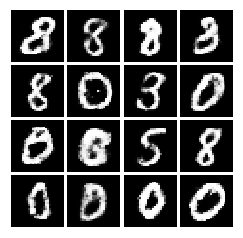

############################
Iter: 459000
D loss: 0.327
G_loss: 3.043


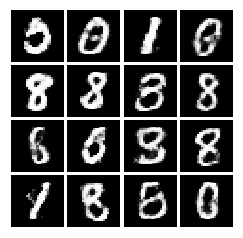

############################
Iter: 460000
D loss: 0.4413
G_loss: 3.457


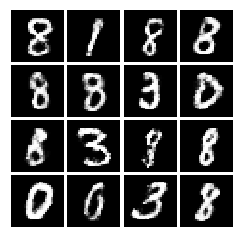

############################
Iter: 461000
D loss: 0.4176
G_loss: 2.972


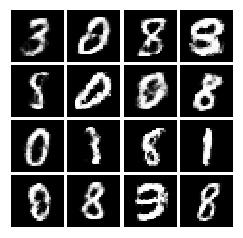

############################
Iter: 462000
D loss: 0.3423
G_loss: 3.293


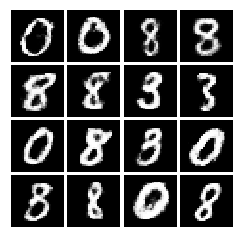

############################
Iter: 463000
D loss: 0.3908
G_loss: 2.804


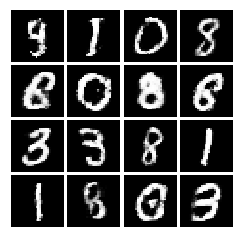

############################
Iter: 464000
D loss: 0.5005
G_loss: 2.859


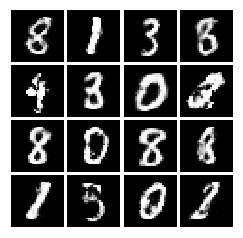

############################
Iter: 465000
D loss: 0.3544
G_loss: 2.767


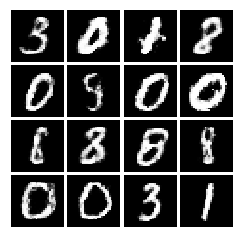

############################
Iter: 466000
D loss: 0.4056
G_loss: 2.739


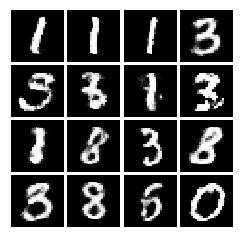

############################
Iter: 467000
D loss: 0.4736
G_loss: 3.483


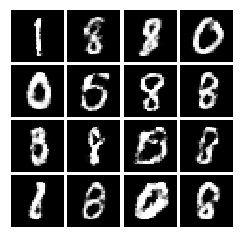

############################
Iter: 468000
D loss: 0.5309
G_loss: 3.588


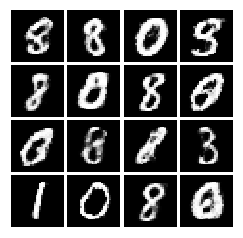

############################
Iter: 469000
D loss: 0.409
G_loss: 2.941


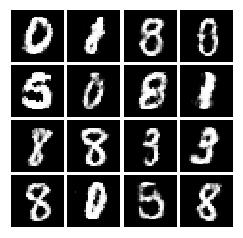

############################
Iter: 470000
D loss: 0.322
G_loss: 2.895


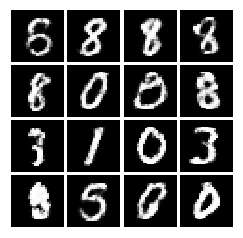

############################
Iter: 471000
D loss: 0.5031
G_loss: 2.873


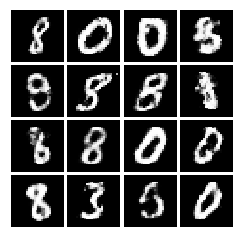

############################
Iter: 472000
D loss: 0.4678
G_loss: 3.331


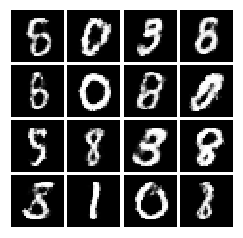

############################
Iter: 473000
D loss: 0.4335
G_loss: 2.876


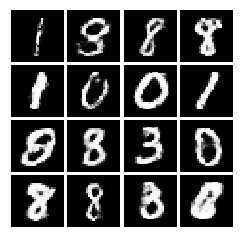

############################
Iter: 474000
D loss: 0.4048
G_loss: 3.13


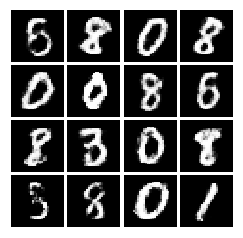

############################
Iter: 475000
D loss: 0.4845
G_loss: 3.049


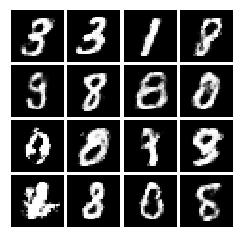

############################
Iter: 476000
D loss: 0.4036
G_loss: 3.024


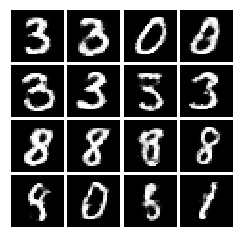

############################
Iter: 477000
D loss: 0.3036
G_loss: 3.114


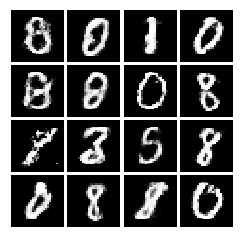

############################
Iter: 478000
D loss: 0.3613
G_loss: 3.225


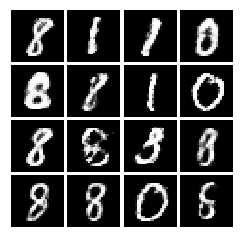

############################
Iter: 479000
D loss: 0.4352
G_loss: 3.379


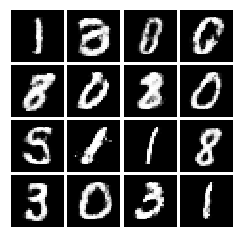

############################


KeyboardInterrupt: 

In [22]:
for it in range(max_iter):

    #### train ####
    X, _ = mnist.train.next_batch(batch_size)

    _, D_loss_curr = sess.run([D_optimizer, D_loss], feed_dict={input_img: X, Z: sample_Z(batch_size, Z_dim)})
    _, G_loss_curr = sess.run([G_optimizer, G_loss], feed_dict={Z: sample_Z(batch_size, Z_dim)})

    if it % 1000 == 0:
        print('Iter: {}'.format(it))
        print('D loss: {:.4}'. format(D_loss_curr))
        print('G_loss: {:.4}'.format(G_loss_curr))
                                     
        samples = sess.run(G_sample, feed_dict={Z: sample_Z(16, Z_dim)})
        fig = plot(samples)
        plt.show()
        plt.close(fig)
        print('############################')
                                     
                                     